In [1]:
%pip install bs4 
%pip install lxml
%pip install openpyxl
%pip install html5liba

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement html5liba (from versions: none)
ERROR: No matching distribution found for html5liba
Note: you may need to restart the kernel to use updated packages.


In [1]:
from bs4 import BeautifulSoup
import re
import random
from pathlib import Path

import os
import io

import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import r2_score, mean_absolute_error
import  time, copy

# Lecture des données : 
#### veuillez mettre tous les fichier .xls dans un seul dossier et remplacer le nouveau PATH 

In [2]:
def extract_all_itavi_data_final(root_dir):
    """
    Fonction de lecture et d’extraction des fichiers ITAVI (.xls).
    
    - Parcourt tous les fichiers présents dans le dossier `root_dir`.
    - Extrait deux tables principales :
        * Table 0 : informations générales sur le lot.
        * Table 2 : données expérimentales (poids, âge, alimentation, etc.).
    - Nettoie les colonnes (suppression des MultiIndex inutiles).
    - Crée dynamiquement deux variables globales par fichier :
        * `df_Lot_X`   : contient les données de la table 2.
        * `info_Lot_X` : contient les informations de la table 0.
      Le nom X correspond à l’identifiant du lot extrait du nom du fichier.
    """

    root = Path(root_dir)
    xls_files = [f for f in root.glob("*.xls") if f.is_file()]
    
    print("--- Début de la lecture et de la création des DataFrames ---")
    
    nombre_lots_crees = 0

    for file_path in xls_files:
        file_name = file_path.name.lower()
        
        # On ne garde que les fichiers commençant par "lot" ou "synthese"
        if not (file_name.startswith("lot") or file_name.startswith("synthese")):
            continue

        try:
            # Lecture du fichier en tant que HTML (encodage latin1 obligatoire)
            with open(file_path, "r", encoding="latin1") as f:
                html_content = f.read()
            tables = pd.read_html(io.StringIO(html_content))

            # On attend au moins 3 tables (la 0 et la 2 sont nécessaires)
            if len(tables) < 3:
                print(f"[!] Moins de 3 tables dans {file_path.name}, fichier ignoré.")
                continue
            
            # Table 0 : infos générales / Table 2 : données expérimentales
            df_info = tables[0]
            df_data = tables[2]
            
        except Exception as e:
            print(f"[ERREUR] Impossible de traiter {file_path.name} : {e}")
            continue
        
        # Nettoyage des colonnes si MultiIndex (on simplifie les noms)
        for df in [df_info, df_data]:
            if isinstance(df.columns, pd.MultiIndex):
                df.columns = [
                    col[0] if col[0] == col[1] or pd.isna(col[1]) or col[1] == '' else f"{col[0]}_{col[1]}"
                    for col in df.columns
                ]
            df.reset_index(drop=True, inplace=True)

        # Extraction d’un identifiant à partir du nom de fichier (lot, synthèse, etc.)
        base_name = file_path.stem
        match = re.match(r"(lot|synthese)\s*([a-zA-Z0-9\-\s\.]+)", base_name, re.IGNORECASE)
        
        if match:
            identifier = match.group(2).strip()
            clean_identifier = re.sub(r'[^a-zA-Z0-9]+', '_', identifier)
            var_name_base = f"df_Lot_{clean_identifier}"
        else:
            clean_base_name = re.sub(r'[^a-zA-Z0-9]+', '_', base_name)
            var_name_base = f"df_Lot_{clean_base_name}"

        # Nettoyage supplémentaire du nom pour éviter les doublons ou suffixes
        var_name_base = var_name_base.replace('df_Lot__', 'df_Lot_').replace('synthese_', '')
        parts = var_name_base.split('_')
        if len(parts) > 2 and (parts[1].lower() == 'lot'):
            var_name_base = f"df_Lot_{'_'.join(parts[2:])}"
        if var_name_base.endswith('_'):
            var_name_base = var_name_base[:-1]

        # Exemple de nom final : "df_Lot_44"
        
        # Création des deux variables globales (data + infos)
        globals()[var_name_base] = df_data
        globals()[var_name_base.replace('df_', 'info_')] = df_info
        
        print(f"✅ Variables créées : {var_name_base} et {var_name_base.replace('df_', 'info_')}")
        nombre_lots_crees += 1

    print(f"\n--- Fin de la lecture. {nombre_lots_crees} lots ont été chargés. ---")


# --- Exécution de la fonction pour charger les fichiers ITAVI ---
# CHANGER ICI LE NOUVEAU PATH :
extract_all_itavi_data_final("/kaggle/input/itavi-dataset")


--- Début de la lecture et de la création des DataFrames ---
✅ Variables créées : df_Lot_44 et info_Lot_44
[ERREUR] Impossible de traiter Lot 55.xls : No tables found
✅ Variables créées : df_Lot_2 et info_Lot_2
✅ Variables créées : df_Lot_12 et info_Lot_12
✅ Variables créées : df_Lot_8 et info_Lot_8
[ERREUR] Impossible de traiter Lot 53.xls : No tables found
✅ Variables créées : df_Lot_27 et info_Lot_27
✅ Variables créées : df_Lot_9 et info_Lot_9
✅ Variables créées : df_Lot_29 et info_Lot_29
✅ Variables créées : df_Lot_46 et info_Lot_46
[ERREUR] Impossible de traiter Lot 50.xls : No tables found
✅ Variables créées : df_Lot_39 et info_Lot_39
✅ Variables créées : df_Lot_A et info_Lot_A
✅ Variables créées : df_Lot_67 et info_Lot_67
✅ Variables créées : df_Lot_47 et info_Lot_47
✅ Variables créées : df_Lot_24 et info_Lot_24
[ERREUR] Impossible de traiter synthese35.xls : No tables found
✅ Variables créées : df_Lot_1 et info_Lot_1
✅ Variables créées : df_Lot_19 et info_Lot_19
✅ Variables cré

# Nettoyage et Harmonisation des noms de variable

In [3]:
import re
import unicodedata


# Dictionnaire permettant de mapper différentes variantes de noms de colonnes
# (alias) vers une version canonique et standardisée.
# Exemple : "Date" → "date", "Age" → "age".
ALIAS2CANON = {
    "Date": "date",
    "Age":  "age",

    # Variables "Mixtes"
    "Mixtes_Nombres":   "mixtes_nombres",
    "Mixtes_Morts":     "mixtes_morts",
    "Mixtes_Eliminés":  "mixtes_elimines",
    "Mixtes_Cardiaques":"mixtes_cardiaques",
    "Mixtes_Sortis":    "mixtes_sortis",
    "Mixtes_Poids":     "mixtes_poids",
    "Mixtes_GMQ":       "mixtes_gmq",
    "Mixtes":           "mixtes_gmq",   

    # Variables liées à l’alimentation
    "Aliment_Kg":       "aliment_kg",
    "CHAINES_Kg":       "aliment_kg",
    "chaines_Kg":       "aliment_kg",
    "chaine_Kg":        "aliment_kg",
    "chaine_kg":        "aliment_kg",
    "Chaine 2_Kg":      "aliment_kg",
    "chaine_2_kg":      "aliment_kg",
    "chaines cotés_Kg": "aliment_kg",
    "chaine milieu_Kg": "aliment_kg",
    "CHAINE EXTERIEUR_Kg": "aliment_kg",
    "CHAINE INTERIEUR_Kg": "aliment_kg",

    # Eau
    "Eau_L":            "eau_l",
    "eau_L":            "eau_l",
    "Eau":              "eau_l",
    "EAU 1_L":          "eau_l",
    "Eau 1_L":          "eau_l",
    "EAU N°1_L":        "eau_l",
    "Eau N°1_L":        "eau_l",
    "eau_1_l":          "eau_l",
    "eau_n_1_l":        "eau_l",
    "eau_1":            "eau_l",
    "eau_n_1":          "eau_l",

    # Brumisation
    "BRUME_L":          "brume_l",
    "Brume_L":          "brume_l",
    "brume_L":          "brume_l",
    "BRUME":            "brume_l",
    "BRUMISATION_L":    "brume_l",
    "Brumisation_L":    "brume_l",

    # Lavage
    "LAVAGE_L":         "lavage_l",
    "lavage_L":         "lavage_l",
    "LAVAGE":           "lavage_l",

    # Vidange
    "Vidange_L":        "vidange_l",
    "Vidange":          "vidange_l",

    # Températures
    "Temp_Mini":        "temp_mini",
    "Temp_Maxi":        "temp_maxi",
    "Temp":             "temp_mini",
    "Temp Ext_Mini":    "temp_ext_mini",
    "temp_ext":         "temp_ext_mini",
    "Temp Ext_Maxi":    "temp_ext_maxi",

    # Hygrométrie
    "Hygro_Mini":       "hygro_mini",
    "Hygro_Maxi":       "hygro_maxi",
    "Hygro":            "hygro_mini",
    "Hygro Ext_Mini":   "hygro_ext_mini",
    "Hygro Ext_Maxi":   "hygro_ext_maxi",

    # Air et gaz
    "Air_m3/h":         "air_m3_h",
    "air":              "air_m3_h",
    "Gaz_M3":           "gaz_m3",
    "gaz_M3":           "gaz_m3",
    "Gaz":              "gaz_m3",
    "Gaz_Kg":           "gaz_kg",

    # Énergie
    "Energie_Kw":       "energie_kw",
    "electricité_Kw":   "energie_kw",
    "électricité_Kw":   "energie_kw",
    "electricite":      "energie_kw",
    "energie":          "energie_kw",

    # Vis
    "VIS_Kg":           "vis_kg",
    "vis_Kg":           "vis_kg",
    "vis":              "vis_kg",

    # Silos
    "silo 1_Kg":        "silo_1_kg",
    "silo 2_Kg":        "silo_2_kg",
    "silo 3_Kg":        "silo_3_kg",
    "silo 1":           "silo_1_kg",
    "silo 2":           "silo_2_kg",
    "silo 3":           "silo_3_kg",
}


def normalize(col: str) -> str:
    """
    Normalise un nom de colonne :
    - Supprime les accents
    - Convertit en minuscules
    - Remplace les caractères non alphanumériques par des underscores
    - Supprime les underscores en trop
    """
    col = ''.join(
        c for c in unicodedata.normalize('NFD', str(col))
        if unicodedata.category(c) != 'Mn'  # enlève les diacritiques (accents)
    )
    col = col.lower()
    col = re.sub(r'[^a-z0-9]+', '_', col)   # remplace tout sauf lettres/chiffres
    col = re.sub(r'_+', '_', col).strip('_') # réduit les underscores multiples
    return col


def canonize_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Harmonise les noms de colonnes d’un DataFrame en appliquant :
    - La correspondance avec ALIAS2CANON si disponible
    - La fonction normalize sinon
    """
    new_cols = []
    for c in df.columns:
        # Si le nom de colonne est déjà dans ALIAS2CANON
        if str(c) in ALIAS2CANON:
            new_cols.append(ALIAS2CANON[str(c)])
            continue

        # Sinon on normalise et on vérifie à nouveau
        norm = normalize(c)
        if norm in ALIAS2CANON:
            new_cols.append(ALIAS2CANON[norm])
        else:
            new_cols.append(norm)

    out = df.copy()
    out.columns = new_cols
    return out


# Parcourt toutes les variables globales dont le nom commence par "df_Lot_"
# et applique la fonction de canonisation des colonnes.
for var in [v for v in globals() if v.startswith("df_Lot_")]:
    globals()[var] = canonize_df(globals()[var])
    print(f"Colonnes harmonisées pour {var}")


✅ Colonnes harmonisées pour df_Lot_44
✅ Colonnes harmonisées pour df_Lot_2
✅ Colonnes harmonisées pour df_Lot_12
✅ Colonnes harmonisées pour df_Lot_8
✅ Colonnes harmonisées pour df_Lot_27
✅ Colonnes harmonisées pour df_Lot_9
✅ Colonnes harmonisées pour df_Lot_29
✅ Colonnes harmonisées pour df_Lot_46
✅ Colonnes harmonisées pour df_Lot_39
✅ Colonnes harmonisées pour df_Lot_A
✅ Colonnes harmonisées pour df_Lot_67
✅ Colonnes harmonisées pour df_Lot_47
✅ Colonnes harmonisées pour df_Lot_24
✅ Colonnes harmonisées pour df_Lot_1
✅ Colonnes harmonisées pour df_Lot_19
✅ Colonnes harmonisées pour df_Lot_26
✅ Colonnes harmonisées pour df_Lot_10
✅ Colonnes harmonisées pour df_Lot_42
✅ Colonnes harmonisées pour df_Lot_13
✅ Colonnes harmonisées pour df_Lot_69
✅ Colonnes harmonisées pour df_Lot_49
✅ Colonnes harmonisées pour df_Lot_3
✅ Colonnes harmonisées pour df_Lot_25
✅ Colonnes harmonisées pour df_Lot_B
✅ Colonnes harmonisées pour df_Lot_58
✅ Colonnes harmonisées pour df_Lot_11
✅ Colonnes harmonis

In [4]:
def _clean_series(ser: pd.Series) -> pd.Series:
    """
    Nettoie une série Pandas contenant des valeurs textuelles qui devraient
    représenter des nombres.  
    Étapes :
    - Convertit en chaîne de caractères pour pouvoir appliquer .str
    - Remplace les virgules par des points (standard décimal)
    - Supprime les tirets doublés et autres artéfacts
    - Retire tous les caractères non numériques (hors chiffres, point, tiret)
    - Conserve au maximum un seul point décimal
    - Convertit en valeurs numériques (float), avec NaN en cas d’échec
    """
    # Conversion en chaîne pour uniformiser le traitement
    ser = ser.astype(str)
    
    # Remplacements successifs pour nettoyer la série
    ser = (
        ser.str.replace(",", ".", regex=False)         # transforme ',' en '.'
           .str.replace("--", "", regex=False)         # supprime les doubles tirets
           .str.replace(r"[^\d\.\-]", "", regex=True)  # ne garde que chiffres, ., -
           .str.replace(r"\.(?=.*\.)", "", regex=True) # supprime les points en trop
    )
    
    # Conversion finale en nombre, valeurs invalides → NaN
    return pd.to_numeric(ser, errors="coerce")
    

def _rename_duplicate_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Renomme les colonnes du DataFrame si certaines sont dupliquées.  
    Exemple : ['A', 'B', 'A'] devient ['A', 'B', 'A_1'].
    """
    cols = pd.Series(df.columns)
    
    # Parcourt chaque colonne dupliquée et ajoute un suffixe incrémenté
    for dup in cols[cols.duplicated()].unique():
        cols[cols[cols == dup].index.values.tolist()] = [
            dup if i == 0 else f"{dup}_{i}" for i, c in enumerate(cols[cols == dup])
        ]
    
    df.columns = cols
    return df


## Sélection des lots cycle standard

In [5]:
# --- 1. Définition des seuils de filtrage ---
SEUIL_MIN_JOURS = 30         # Minimum de jours requis pour conserver un lot
SEUIL_MAX_JOURS = 55         # Âge maximum autorisé
LONGUEUR_SEQUENCE_FIXE = 46  # Taille fixe de séquence (jusqu’à 45 jours)

print("--- Début de la préparation des données pour les lots 'standards' ---")
print(f"Critères : Nombre de jours >= {SEUIL_MIN_JOURS} ET Âge max <= {SEUIL_MAX_JOURS}")

# --- 2. Audit et filtrage des lots ---
lots_valides = []           # Liste des lots conservés
donnees_lots_valides = []   # Données correspondantes aux lots retenus

# Parcourt toutes les variables globales de type DataFrame commençant par "df_Lot_"
for var in [v for v in globals() if v.startswith("df_Lot_")]:
    lot_name = var.replace("df_", "")       # Extrait l’identifiant du lot
    df_lot_brut = globals()[var]            # Récupère le DataFrame associé
    df = df_lot_brut.copy()                 # Copie de sécurité

    # Harmonisation et nettoyage
    df = _rename_duplicate_columns(df)      # Supprime les doublons de colonnes
    df = canonize_df(df)                    # Canonise les noms de colonnes
    if 'age' not in df.columns:
        continue
    
    # Nettoyage et conversion de la colonne "age"
    df['age'] = _clean_series(df['age'])
    df.dropna(subset=['age'], inplace=True)
    if df.empty:
        continue
    df['age'] = df['age'].astype(int)
    df = df[df['age'] >= 0]
    if df.empty:
        continue

    # Vérification des conditions de filtrage
    nb_jours_valides = len(df)
    age_max = df['age'].max()

    if SEUIL_MIN_JOURS <= nb_jours_valides and age_max <= SEUIL_MAX_JOURS:
        lots_valides.append(lot_name)
        df['Lot_ID'] = lot_name  # Ajout d’un identifiant pour ce lot
        donnees_lots_valides.append(df)
    else:
        print(f"INFO : Lot '{lot_name}' écarté (Jours: {nb_jours_valides}, Âge max: {age_max})")

print(f"\n{len(lots_valides)} lots ont été conservés pour l'entraînement et le test.")

# --- 3. Construction du DataFrame global X_all ---
if donnees_lots_valides:
    X_all = pd.concat(donnees_lots_valides, ignore_index=True)
    print(f"DataFrame 'X_all' final créé avec la shape : {X_all.shape}")
else:
    raise ValueError("Aucun lot ne correspond aux critères de filtrage. Impossible de continuer.")

# --- 4. Création de la matrice de poids avec padding ---
def creer_matrice_paddee(df_source, liste_lots, longueur_fixe):
    """
    Construit une matrice 3D (lots x temps x 1) contenant les poids par jour,
    avec remplissage (padding) pour uniformiser la longueur des séquences.
    
    Paramètres :
    - df_source : DataFrame contenant les données fusionnées
    - liste_lots : liste des identifiants de lots à inclure
    - longueur_fixe : longueur de séquence imposée
    
    Retourne :
    - matrice numpy de dimension (nb_lots, longueur_fixe, 1)
    """
    id_col = 'Lot_ID'
    time_col = 'age'
    value_col = 'mixtes_poids'
    
    n_lots = len(liste_lots)
    matrice_brute = np.full((n_lots, longueur_fixe, 1), np.nan)

    for idx, lot_id in enumerate(liste_lots):
        group = df_source[df_source[id_col] == lot_id]
        if group.empty:
            continue

        jours = group[time_col].values
        poids = _clean_series(group[value_col]).values

        # On garde uniquement les jours dans la limite imposée
        mask = jours < longueur_fixe
        matrice_brute[idx, jours[mask], 0] = poids[mask]

        # On complète les valeurs manquantes par ffill/bfill
        s = pd.Series(matrice_brute[idx, :, 0])
        s.ffill(inplace=True)
        s.bfill(inplace=True)
        matrice_brute[idx, :, 0] = s.values

    return matrice_brute

# Application de la fonction de construction
matrice_poids_bruts_paddee = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=lots_valides,
    longueur_fixe=LONGUEUR_SEQUENCE_FIXE
)

# --- 5. Normalisation globale des poids ---
mean_global = np.nanmean(matrice_poids_bruts_paddee)
std_global = np.nanstd(matrice_poids_bruts_paddee)
scaler_global = {'mean': mean_global, 'std': std_global}

# Normalisation (centrage-réduction)
donnees_normalisees = (matrice_poids_bruts_paddee - mean_global) / std_global

print("\n--- Données des lots 'standards' préparées et normalisées ---")
print(f"Shape de la matrice normalisée finale : {donnees_normalisees.shape}")
print(f"Scaler global : Mean={mean_global:.2f}, Std={std_global:.2f}")


--- Début de la préparation des données pour les lots 'standards' ---
Critères : Nombre de jours de données >= 30 ET Âge maximum <= 55
INFO : Lot 'Lot_12' écarté (Jours: 22, Âge max: 21)
INFO : Lot 'Lot_58' écarté (Jours: 86, Âge max: 85)
INFO : Lot 'Lot_59_Rennes_LP_2024' écarté (Jours: 88, Âge max: 87)
INFO : Lot 'Lot_59' écarté (Jours: 88, Âge max: 87)
INFO : Lot 'Lot_70' écarté (Jours: 109, Âge max: 108)
INFO : Lot 'Lot_68' écarté (Jours: 109, Âge max: 108)
INFO : Lot 'Lot_C' écarté (Jours: 86, Âge max: 85)
INFO : Lot 'Lot_61' écarté (Jours: 88, Âge max: 87)
INFO : Lot 'Lot_23' écarté (Jours: 14, Âge max: 13)

48 lots ont été conservés pour l'entraînement et le test.
DataFrame 'X_all' final créé avec la shape : (1862, 28)

--- Données des lots 'standards' préparées et normalisées ---
Shape de la matrice normalisée finale : (48, 46, 1)
Scaler global : Mean=1073.65, Std=773.68


---

# Partie EDA et visualisations :

In [8]:
import plotly.express as px
import pandas as pd

# Copie du DataFrame
df_audit = df_meta.copy()
df_audit = df_audit[~( (df_audit['duree_de_vie'] == 13.0))].copy()
min_duree = df_audit['duree_de_vie'].min()
x_min = int(min_duree) - 1

# Création de l'histogramme
fig = px.histogram(
    df_audit,
    x='duree_de_vie',
    nbins=50,
    title="Distribution de l'âge maximum par lot",
    labels={'duree_de_vie': "Âge maximum (jours)", 'count': "Nombre de lots"},
    color_discrete_sequence=["#636EFA"]
)

# Mise en forme esthétique + axes visibles
fig.update_layout(
    width=700, 
    height=500, 
    title_font_size=20,
    xaxis_title="Âge maximum (jours)",
    yaxis_title="Nombre de lots",
     xaxis=dict(
        range=[0, 100],  # Début à la première vraie valeur
        showline=True,
        dtick=10,
        linewidth=1,
        linecolor='black',
        mirror=True
    ),
 
    yaxis=dict(
        showline=True,
        linewidth=1,
        linecolor='black',
        mirror=True
    ),
    bargap=0.05,
    plot_bgcolor='white',
    margin=dict(l=50, r=50, t=60, b=50),
)

fig.update_traces(marker_line_color='white', marker_line_width=1)

# Affichage interactif (pour téléchargement manuel)
fig.show()


In [9]:
import pandas as pd
import numpy as np

print("--- Lancement de l'audit de la durée des lots ---")

audit_results = []

# On boucle sur toutes les variables df_Lot_... que vous avez créées
for var in [v for v in globals() if v.startswith("df_Lot_")]:
    lot_name = var.replace("df_", "")
    df_lot_brut = globals()[var]
    df = df_lot_brut.copy()

    # --- Étape 1 : Nettoyage de base juste pour l'audit ---
    
    # On s'assure que la colonne 'age' existe après canonisation
    df = canonize_df(df)
    
    if 'age' not in df.columns:
        print(f"INFO [{lot_name}]: Colonne 'age' non trouvée, lot ignoré pour l'audit.")
        continue
        
    # On nettoie la colonne 'age' (gère les 'Total', etc. en les passant en NaN)
    df['age'] = _clean_series(df['age'])
    
    # On supprime les lignes où l'âge est manquant
    df.dropna(subset=['age'], inplace=True)
    if df.empty: continue
        
    # On s'assure que c'est un entier et qu'il est positif
    df['age'] = df['age'].astype(int)
    df = df[df['age'] >= 0]
    if df.empty: continue

    # --- Étape 2 : Calcul des métriques ---
    nombre_de_jours_valides = len(df)
    age_max = df['age'].max()
    
    audit_results.append({
        'Lot_ID': lot_name,
        'nb_jours_valides': nombre_de_jours_valides,
        'age_max': age_max
    })

# --- Étape 3 : Affichage du rapport ---
if audit_results:
    df_audit = pd.DataFrame(audit_results)
    df_audit = df_audit.sort_values(by='nb_jours_valides', ascending=False)
    
    print("\n--- RAPPORT D'AUDIT COMPLET ---")
    # On utilise set_option pour afficher toutes les lignes
    pd.set_option('display.max_rows', len(df_audit))
    print(df_audit)
    pd.reset_option('display.max_rows')
    
    # --- Suggestion de seuils ---
    print("\n--- Suggestions ---")
    seuil_min_recommande = 30 # On peut ajuster
    seuil_max_recommande = 45 # On peut ajuster
    
    lots_courts_a_ecarter = df_audit[df_audit['nb_jours_valides'] < seuil_min_recommande]
    lots_longs_a_ecarter = df_audit[df_audit['age_max'] > seuil_max_recommande]
    
    print(f"\nAvec un seuil MINIMUM de {seuil_min_recommande} jours de données, vous écarteriez {len(lots_courts_a_ecarter)} lots :")
    print(lots_courts_a_ecarter['Lot_ID'].tolist())
    
    print(f"\nAvec un seuil MAXIMUM de {seuil_max_recommande} jours, vous écarteriez {len(lots_longs_a_ecarter)} lots (les cycles longs) :")
    print(lots_longs_a_ecarter['Lot_ID'].tolist())
    
else:
    print("Aucun lot valide n'a été trouvé pour l'audit.")

--- Lancement de l'audit de la durée des lots ---

--- RAPPORT D'AUDIT COMPLET ---
                   Lot_ID  nb_jours_valides  age_max
34                 Lot_70               109      108
36                 Lot_68               109      108
31                 Lot_59                88       87
39                 Lot_61                88       87
30  Lot_59_Rennes_LP_2024                88       87
38                  Lot_C                86       85
24                 Lot_58                86       85
10                 Lot_67                54       53
19                 Lot_69                53       52
20                 Lot_49                43       42
18                 Lot_13                42       41
17                 Lot_42                42       41
16                 Lot_10                42       41
56                  Lot_6                42       41
33                 Lot_41                42       41
51                 Lot_17                42       41
54              

In [6]:
def prepare_data_for_timeflow_safe(df: pd.DataFrame, lot_name: str):
    """
    Cette fonction préserve l'intégrité de la série temporelle.
    Elle ne supprime QUE les lignes où l'âge est manquant ou négatif.
    """
    if df.empty:
        return pd.DataFrame()

    # 1. Copie et renommage des colonnes dupliquées (bonne pratique)
    df = df.copy()
    df = _rename_duplicate_columns(df)

    # 2. On s'assure que les colonnes essentielles existent
    if 'age' not in df.columns or 'mixtes_poids' not in df.columns:
        print(f"AVERTISSEMENT [{lot_name}]: Colonnes 'age' ou 'mixtes_poids' manquantes. Lot ignoré.")
        return pd.DataFrame()

    # 3. Nettoyage CIBLÉ des colonnes, sans appliquer de filtres globaux
    df['age'] = _clean_series(df['age'])
    df['mixtes_poids'] = _clean_series(df['mixtes_poids'])

    # 4. GESTION DES PROBLÈMES DE DONNÉES (la partie la plus importante)
    
    # a) Supprimer les lignes où l'âge est complètement manquant après nettoyage
    df.dropna(subset=['age'], inplace=True)
    if df.empty:
        print(f"AVERTISSEMENT [{lot_name}]: Aucune ligne avec un âge valide. Lot ignoré.")
        return pd.DataFrame()
        
    # b) S'assurer que 'age' est un entier
    df['age'] = df['age'].astype(int)
    
    # c) Supprimer les âges négatifs (cas du Lot 30)
    df = df[df['age'] >= 0]
    if df.empty:
        print(f"AVERTISSEMENT [{lot_name}]: Aucune ligne avec un âge positif ou nul. Lot ignoré.")
        return pd.DataFrame()

    # 5. Sélection et tri final
    
    # On garde les colonnes essentielles
    df_final = df[['age', 'mixtes_poids']].copy()
    
    # On supprime les jours dupliqués en gardant la PREMIÈRE occurrence.
    # Cela résout les problèmes de "valeurs au milieu non prises".
    df_final = df_final.drop_duplicates(subset=['age'], keep='first')
    
    # On trie par âge pour garantir l'ordre chronologique.
    # Cela résout les problèmes de "non ordonné".
    df_final = df_final.sort_values(by='age').reset_index(drop=True)

    return df_final

# --- NOUVELLE BOUCLE DE CRÉATION DE X_all (inchangée mais cruciale) ---

# ... (votre code qui définit les df_Lot_... est ici)

# On canonise les colonnes une seule fois au début
for var in [v for v in globals() if v.startswith("df_Lot_")]:
    globals()[var] = canonize_df(globals()[var])

X_all_list = []
for var in [v for v in globals() if v.startswith("df_Lot_")]:
    lot_name = var.replace("df_", "")
    df_lot = globals()[var]
    
    # On appelle notre nouvelle fonction "sûre"
    df_lot_prepare = prepare_data_for_timeflow_safe(df_lot, lot_name)

    if df_lot_prepare.empty:
        continue

    df_lot_prepare["Lot_ID"] = lot_name
    X_all_list.append(df_lot_prepare)

if X_all_list:
    X_all = pd.concat(X_all_list, ignore_index=True)
    print("DataFrame X_all final créé.")
    print(X_all.info())
else:
    print("Aucun lot n'a pu être traité.")
    X_all = pd.DataFrame()

DataFrame X_all final créé.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2552 entries, 0 to 2551
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           2552 non-null   int64  
 1   mixtes_poids  2552 non-null   float64
 2   Lot_ID        2552 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 59.9+ KB
None


In [92]:
import plotly.graph_objects as go
import plotly.express as px
import pandas as pd
import numpy as np

# Filtrer pour des lots courts
X_all_filtré = X_all.groupby('Lot_ID').filter(lambda x: len(x) <= 50)

# Sélection de 1 lot (change size=10 si tu veux 10 lots)
lots_selectionnes = np.random.choice(X_all_filtré['Lot_ID'].unique(), size=1, replace=False)

# Données des lots sélectionnés
df_lots = X_all[X_all['Lot_ID'].isin(lots_selectionnes)]

# Courbe moyenne (par âge) - optionnelle
df_moyenne = (
    X_all_filtré.groupby('age')['mixtes_poids']
    .mean()
    .reset_index()
    .rename(columns={'mixtes_poids': 'poids_moyen'})
)

# Figure
fig = go.Figure()

# Tracer une courbe par lot
for lot in lots_selectionnes:
    data_lot = df_lots[df_lots['Lot_ID'] == lot].sort_values('age')
    fig.add_trace(go.Scatter(
        x=data_lot['age'],
        y=data_lot['mixtes_poids'],
        mode='lines',
        name=f'{lot}',           # lisible dans la légende
        opacity=0.4,
        line=dict(width=2)
    ))

    # --- NOUVEAU : annotation avec le nom du lot au dernier point ---
    x_last = data_lot['age'].iloc[-1]
    y_last = data_lot['mixtes_poids'].iloc[-1]
    fig.add_annotation(
        x=x_last, y=y_last,
        text=f"{lot}",
        showarrow=False,
        xanchor="left", yanchor="middle",
        xshift=6,  # petit décalage à droite pour ne pas chevaucher la courbe
        font=dict(size=12)
    )

# (Optionnel) courbe moyenne
# fig.add_trace(go.Scatter(
#     x=df_moyenne['age'], y=df_moyenne['poids_moyen'],
#     mode='lines', name='Tendance moyenne',
#     opacity=0.5, line=dict(color='red', width=3)
# ))

# Mise en page
fig.update_layout(
    title="Courbes de Croissance de lot",
    xaxis_title="Âge (jours)",
    yaxis_title="Poids (g)",
    plot_bgcolor='white',
    legend_title="Lots",
    width=900,
    height=600,
    margin=dict(l=60, r=110, t=60, b=60),  # marge droite augmentée pour les labels
    font=dict(size=14),
    xaxis=dict(showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showgrid=True, gridcolor='lightgray')
)

fig.show()


In [12]:
import plotly.graph_objects as go
import pandas as pd
import numpy as np

# --- cible : Lot_15 et Lot_19, quels que soient les formats d'ID ---
candidats = [15, 19, '15', '19', 'Lot_15', 'Lot_19']
present_ids = [c for c in candidats if c in set(X_all['Lot_ID'].unique())]

if not present_ids:
    raise ValueError("Ni Lot_15 ni Lot_19 trouvés dans X_all['Lot_ID'].")

def plot_lot(df, lot_id, color='red', width=5):
    data_lot = df[df['Lot_ID'] == lot_id].sort_values('age')
    if data_lot.empty:
        print(f"Avertissement : {lot_id} introuvable, on passe.")
        return

    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=data_lot['age'],
        y=data_lot['mixtes_poids'],
        mode='lines',
        name=f'{lot_id}',
        line=dict(color=color, width=width)
    ))

    # Annotation du nom du lot au dernier point
    x_last = data_lot['age'].iloc[-1]
    y_last = data_lot['mixtes_poids'].iloc[-1]
    fig.add_annotation(
        x=x_last, y=y_last, text=f"{lot_id}",
        showarrow=False, xanchor="left", yanchor="middle", xshift=6
    )

    # --- Ligne verticale au jour 30 ---
    fig.add_vline(
        x=30,
        line=dict(color="green", width=2, dash="dot"),
        annotation_text="Jour 30",
        annotation_position="top"
    )

    fig.update_layout(
        title=f"Courbe de croissance du {lot_id}",
        xaxis_title="Âge (jours)",
        yaxis_title="Poids (g)",
        template="plotly_white",
        hovermode="x unified",
        width=900, height=500,
        margin=dict(l=60, r=110, t=60, b=60)
    )
    fig.show()

# On ne garde que Lot_15 et Lot_19 (selon ce qui existe réellement)
targets = []
mapping_affichage = {}
for wanted in [('Lot_15', [15, '15', 'Lot_15']), ('Lot_19', [19, '19', 'Lot_19'])]:
    label, variantes = wanted
    for v in variantes:
        if v in present_ids:
            targets.append(v)
            mapping_affichage[v] = label
            break

# Trace un graphe par lot (épais et rouge)
for lot in targets:
    plot_lot(X_all, lot_id=lot, color='red', width=2)


---

# Préparation des Encodeurs :

## Encodeur Statiques ( Souche, id_eleveur, ...)

In [6]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn

# -------------------------------------------------------------------
# CELLULE FINALE : PRÉPARATION DES DONNÉES STATIQUES ET DES ENCODEURS
# -------------------------------------------------------------------

def preparer_donnees_statiques_et_encodeurs(liste_lot_ids):
    """
    Prépare les données statiques pour les lots courts et crée les encodeurs
    PyTorch pour les variables catégorielles 'Couvoir' et 'Eleveur'.

    Étapes principales :
    1. Extraction des informations statiques brutes (Souche, Couvoir, Avitouch)
    2. Nettoyage et harmonisation des valeurs
    3. Imputation des valeurs manquantes
    4. Construction du DataFrame final des métadonnées
    5. Création des encodeurs Embedding pour les variables catégorielles
    """
    print(f"--- Préparation des données statiques pour {len(liste_lot_ids)} lots ---")

    # --- 1. Fonctions utilitaires internes ---
    def extraire_infos_detaillees(df_info):
        """
        Extrait les informations 'souche', 'couvoir', 'avitouch' depuis un DataFrame d'infos brutes.
        """
        infos = {'souche': None, 'couvoir': None, 'avitouch': None}
        try:
            df_info.columns = range(df_info.shape[1])
            # Extraction selon le contenu des colonnes
            souche_ligne = df_info[df_info[2].astype(str).str.contains("Souche", na=False)]
            if not souche_ligne.empty: infos['souche'] = souche_ligne[3].iloc[0]
            couvoir_ligne = df_info[df_info[2].astype(str).str.contains("Couvoir", na=False)]
            if not couvoir_ligne.empty: infos['couvoir'] = couvoir_ligne[3].iloc[0]
            avitouch_ligne = df_info[df_info[2].astype(str).str.contains("AVITOUCH N°", na=False)]
            if not avitouch_ligne.empty: infos['avitouch'] = avitouch_ligne[3].iloc[0]
        except Exception:
            pass
        return infos

    def nettoyer_nom_souche(nom):
        """
        Harmonise le nom de la souche selon certaines règles spécifiques.
        """
        if nom is None or pd.isna(nom): return "INCONNUE"
        s = str(nom).lower().strip()
        if "ross" in s or "308" in s: return "ROSS_308"
        if "s757n" in s or "ng2" in s: return "CYCLE_LONG"
        return s
        
    def harmoniser_couvoir(nom):
        """
        Harmonise le nom du couvoir pour réduire les variations.
        """
        if nom is None or pd.isna(nom): return "INCONNUE"
        s = str(nom).lower().strip().split('.')[0]
        if 'amelly' in s or 'amely' in s: return 'amelly'
        if 'auvergne' in s: return 'auvergne'
        if 'goasduff' in s or 'goasduf' in s: return 'goasduff'
        return s
        
    def extraire_id_eleveur(avitouch):
        """
        Extrait l'identifiant de l'éleveur depuis la chaîne AVITOUCH.
        """
        if avitouch is None or pd.isna(avitouch): return "ID_INCONNU"
        match = re.match(r'^\d+-\d+-\d+', str(avitouch))
        return match.group(0) if match else "ID_INCONNU"

    # --- 2. Extraction et nettoyage des lots demandés ---
    meta_data = []
    for lot_id in liste_lot_ids:
        # Extraction des informations statiques
        var_name_info = f"info_{lot_id}"
        if var_name_info in globals():
            df_info = globals()[var_name_info]
            infos_extraites = extraire_infos_detaillees(df_info)
            souche_nettoyee = nettoyer_nom_souche(infos_extraites['souche'])
            couvoir_nettoye = harmoniser_couvoir(infos_extraites['couvoir'])
            eleveur_id = extraire_id_eleveur(infos_extraites['avitouch'])
        else:
            souche_nettoyee, couvoir_nettoye, eleveur_id = "INCONNUE", "INCONNUE", "ID_INCONNU"

        # Calcul de la durée de vie réelle du lot
        var_name_data = f"df_{lot_id}"
        duree_de_vie = np.nan
        if var_name_data in globals():
            df_data = globals()[var_name_data]
            df_data_cleaned = df_data.copy()
            df_data_cleaned['age'] = _clean_series(df_data_cleaned['age'])
            df_data_cleaned.dropna(subset=['age'], inplace=True)
            if not df_data_cleaned.empty:
                duree_de_vie = df_data_cleaned['age'].max()

        meta_data.append({
            'Lot_ID': lot_id, 
            'Souche': souche_nettoyee, 
            'Couvoir_harmonise': couvoir_nettoye, 
            'Eleveur_ID': eleveur_id,
            'duree_de_vie': duree_de_vie
        })
    
    df_meta = pd.DataFrame(meta_data)
    
    # --- 3. Imputation des valeurs manquantes ---
    for col in ['Souche', 'Couvoir_harmonise', 'Eleveur_ID']:
        df_meta[col].replace("INCONNUE", np.nan, inplace=True)
        valeur_la_plus_frequente = df_meta[col].mode()[0]
        df_meta[col].fillna(valeur_la_plus_frequente, inplace=True)

    # --- 4. Création des ID numériques pour les encodeurs ---
    couvoir_uniques = df_meta['Couvoir_harmonise'].unique().tolist()
    eleveur_uniques = df_meta['Eleveur_ID'].unique().tolist()
    
    couvoir_to_id = {c: i for i, c in enumerate(couvoir_uniques)}
    eleveur_to_id = {e: i for i, e in enumerate(eleveur_uniques)}
    
    df_meta['couvoir_id'] = df_meta['Couvoir_harmonise'].map(couvoir_to_id)
    df_meta['eleveur_id'] = df_meta['Eleveur_ID'].map(eleveur_to_id)

    print("\nDataFrame de métadonnées statiques finalisé :")
    print(df_meta[['Lot_ID', 'Couvoir_harmonise', 'Eleveur_ID','duree_de_vie']].head(50))
    
    # --- 5. Création des encodeurs PyTorch ---
    EMBEDDING_DIM_COUVOIR = 8
    EMBEDDING_DIM_ELEVEUR = 8
    
    encodeur_couvoir = nn.Embedding(num_embeddings=len(couvoir_uniques), embedding_dim=EMBEDDING_DIM_COUVOIR)
    encodeur_eleveur = nn.Embedding(num_embeddings=len(eleveur_uniques), embedding_dim=EMBEDDING_DIM_ELEVEUR)
    
    print(f"\nEncodeurs créés : {len(couvoir_uniques)} couvoirs, {len(eleveur_uniques)} éleveurs.")
    
    return df_meta, encodeur_couvoir, encodeur_eleveur

# -------------------------------------------------------------------
# Application de la fonction sur les lots courts validés
# -------------------------------------------------------------------

# On suppose que `lots_valides` existe et que les variables info_Lot_... sont chargées
df_meta_courts, encodeur_couvoir, encodeur_eleveur = preparer_donnees_statiques_et_encodeurs(lots_valides)
df_meta = df_meta_courts


--- Préparation des données statiques pour 48 lots ---

DataFrame de métadonnées statiques finalisé :
    Lot_ID Couvoir_harmonise   Eleveur_ID  duree_de_vie
0   Lot_44          goasduff  606-448-428          40.0
1    Lot_2               duc  690-448-737          36.0
2    Lot_8          goasduff  690-448-737          37.0
3   Lot_27          goasduff  610-490-070          33.0
4    Lot_9          auvergne  670-370-136          29.0
5   Lot_29          auvergne  610-490-070          33.0
6   Lot_46          goasduff  606-448-428          35.0
7   Lot_39          goasduff  606-448-428          35.0
8    Lot_A          auvergne  670-370-136          29.0
9   Lot_67          goasduff  511-678-677          53.0
10  Lot_47             crest  606-448-428          35.0
11  Lot_24               duc  610-490-070          35.0
12   Lot_1          goasduff  690-448-737          34.0
13  Lot_19            amelly  630-370-029          39.0
14  Lot_26          goasduff  610-490-070          35.0
15

/tmp/ipykernel_36/3609019910.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_meta[col].replace("INCONNUE", np.nan, inplace=True) # Remplacer par NaN pour l'imputation
/tmp/ipykernel_36/3609019910.py:94: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing '

In [10]:
df_meta.head()

,Lot_ID,Souche,Couvoir_harmonise,Eleveur_ID,duree_de_vie,couvoir_id,eleveur_id
0,Lot_44,ROSS_308,goasduff,606-448-428,40.0,0,0
1,Lot_2,ROSS_308,duc,690-448-737,36.0,1,1
2,Lot_8,ROSS_308,goasduff,690-448-737,37.0,0,1
3,Lot_27,ROSS_308,goasduff,610-490-070,33.0,0,2
4,Lot_9,ROSS_308,auvergne,670-370-136,29.0,2,3


# Encodeur Méteo :

In [10]:
import torch
import torch.nn as nn
import re

# -------------------------------------------------------------------
# FONCTION : PRÉPARATION DES DONNÉES MÉTÉO ET DE L'ENCODEUR MLP
# -------------------------------------------------------------------

def preparer_encodeur_meteo_final(liste_lot_ids, df_meta_entree):
    """
    Prépare les données météo pour les lots courts, applique un clipping
    des valeurs aberrantes, met à jour df_meta avec les moyennes par lot,
    et crée un encodeur MLP pour les variables météo.

    Paramètres :
    - liste_lot_ids : liste des identifiants de lots à traiter
    - df_meta_entree : DataFrame contenant les métadonnées statiques

    Retourne :
    - df_meta_updated : DataFrame enrichi des moyennes météo par lot
    - encodeur_meteo : instance PyTorch nn.Module pour encoder les features météo
    """
    print(f"\n--- Préparation des données et de l'encodeur Météo pour {len(liste_lot_ids)} lots ---")

    all_meteo_features_list = []

    # Parcourt chaque lot pour extraire et nettoyer les données météo
    for lot_id in liste_lot_ids:
        var_name = f"df_{lot_id}"
        if var_name in globals():
            df_lot_brut = globals()[var_name]
            df = _rename_duplicate_columns(df_lot_brut.copy())

            meteo_cols_brutes = ['temp_mini', 'temp_maxi', 'hygro_mini', 'hygro_maxi', 'temp_ext_mini', 'temp_ext_maxi']
            if not all(col in df.columns for col in meteo_cols_brutes):
                print(f"INFO [{lot_id}]: Colonnes météo manquantes. Lot ignoré pour ce contexte.")
                continue

            # Nettoyage et conversion des colonnes météo en valeurs numériques
            for col in meteo_cols_brutes:
                df[col] = _clean_series(df[col])
            
            # --- Clipping des valeurs aberrantes ---
            df['temp_mini'] = df['temp_mini'].clip(lower=-3, upper=45)
            df['temp_maxi'] = df['temp_maxi'].clip(lower=0, upper=45)
            df['hygro_mini'] = df['hygro_mini'].clip(lower=0, upper=100)
            df['hygro_maxi'] = df['hygro_maxi'].clip(lower=0, upper=100)
            df['temp_ext_mini'] = df['temp_ext_mini'].clip(lower=-20, upper=50)
            df['temp_ext_maxi'] = df['temp_ext_maxi'].clip(lower=-20, upper=50)
            # --- Fin du clipping ---

            # Calcul des moyennes journalières
            df['temp_int_moy_j'] = df[['temp_mini', 'temp_maxi']].mean(axis=1)
            df['hygro_int_moy_j'] = df[['hygro_mini', 'hygro_maxi']].mean(axis=1)
            df['temp_ext_moy_j'] = df[['temp_ext_mini', 'temp_ext_maxi']].mean(axis=1)
            
            # Sélection des colonnes finales
            df_resultat = df[['temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j']]
            df_resultat.interpolate(method='linear', limit_direction='both', inplace=True)
            df_resultat['Lot_ID'] = lot_id
            all_meteo_features_list.append(df_resultat)

    # Vérification qu'on a bien des données météo à traiter
    if not all_meteo_features_list:
        print("ERREUR : Aucune donnée météo n'a pu être préparée.")
        return df_meta_entree, None

    # Fusion de tous les lots
    X_all_meteo = pd.concat(all_meteo_features_list, ignore_index=True)
    
    # --- Agrégation par lot et mise à jour de df_meta ---
    meteo_features_agg = ['temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j']
    df_meteo_agg = X_all_meteo.groupby('Lot_ID')[meteo_features_agg].mean().reset_index()
    df_meta_updated = pd.merge(df_meta_entree, df_meteo_agg, on='Lot_ID', how='left')

    # Remplissage des valeurs manquantes par la médiane
    medianes = df_meta_updated[meteo_features_agg].median()
    df_meta_updated[meteo_features_agg] = df_meta_updated[meteo_features_agg].fillna(medianes)
    print("df_meta a été enrichi avec les données météo agrégées.")

    # --- Création de l'encodeur MLP pour les features météo ---
    class ContexteEncoderMLP(nn.Module):
        def __init__(self, input_dim, latent_dim):
            super().__init__()
            self.net = nn.Sequential(
                nn.Linear(input_dim, 64),
                nn.ReLU(),
                nn.Linear(64, latent_dim)
            )
        def forward(self, x):
            return self.net(x)

    INPUT_DIM_METEO = len(meteo_features_agg)
    LATENT_DIM_METEO = 16
    encodeur_meteo = ContexteEncoderMLP(input_dim=INPUT_DIM_METEO, latent_dim=LATENT_DIM_METEO)
    print(f"Encodeur Météo (MLP) créé.")

    return df_meta_updated, encodeur_meteo

# -------------------------------------------------------------------
# CELLULE D'APPEL
# -------------------------------------------------------------------
# On suppose que `lots_valides` et `df_meta_courts` existent
df_meta, encodeur_meteo = preparer_encodeur_meteo_final(lots_valides, df_meta_courts)

print("\nAperçu de df_meta après ajout des features météo :")
print(df_meta.head())



--- Préparation des données et de l'encodeur Météo pour 48 lots ---


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/

df_meta a été enrichi avec les données météo agrégées.
Encodeur Météo (MLP) créé.

Aperçu de df_meta après ajout des features météo :
   Lot_ID    Souche Couvoir_harmonise   Eleveur_ID  duree_de_vie  couvoir_id  \
0  Lot_44  ROSS_308          goasduff  606-448-428          40.0           0   
1   Lot_2  ROSS_308               duc  690-448-737          36.0           1   
2   Lot_8  ROSS_308          goasduff  690-448-737          37.0           0   
3  Lot_27  ROSS_308          goasduff  610-490-070          33.0           0   
4   Lot_9  ROSS_308          auvergne  670-370-136          29.0           2   

   eleveur_id  temp_int_moy_j  hygro_int_moy_j  temp_ext_moy_j  
0           0       28.401163        56.965116       26.418605  
1           1       26.761842        48.236842       14.178947  
2           1       24.724359        50.179487       -1.203846  
3           2       26.818421        50.776316       12.505263  
4           3       26.957576        59.484848        9.8803

/tmp/ipykernel_36/141296580.py:54: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/141296580.py:55: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in greater_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning:

invalid value encounte

### Version LSTM pour l'encodeur Météo

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import re
from torch.nn.utils.rnn import pad_sequence # Assurez-vous que cet import est présent

# ===================================================================
# CELLULE DÉDIÉE AUX DONNÉES ET ENCODEUR MÉTÉO (VERSION SÉQUENTIELLE AVEC LSTM)
# ===================================================================

def preparer_encodeur_meteo_sequentiel(liste_lot_ids):
    """
    NOUVELLE VERSION : Prépare les données météo en tant que séries temporelles
    paddées et retourne un encodeur LSTM.
    """
    print(f"\n--- Préparation des données SÉQUENTIELLES Météo pour {len(liste_lot_ids)} lots ---")

    # --- PARTIE 1 : Extraction et nettoyage des séries (inchangée) ---
    all_meteo_series_list = []
    meteo_features = ['temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j']

    for lot_id in liste_lot_ids:
        var_name = f"df_{lot_id}"
        if var_name in globals():
            df_lot_brut = globals()[var_name]
            df = _rename_duplicate_columns(df_lot_brut.copy())

            meteo_cols_brutes = ['temp_mini', 'temp_maxi', 'hygro_mini', 'hygro_maxi', 'temp_ext_mini', 'temp_ext_maxi']
            if not all(col in df.columns for col in meteo_cols_brutes):
                continue

            for col in meteo_cols_brutes: df[col] = _clean_series(df[col])
            
            df['temp_mini'] = df['temp_mini'].clip(lower=-3, upper=45)
            df['temp_maxi'] = df['temp_maxi'].clip(lower=0, upper=45)
            df['hygro_mini'] = df['hygro_mini'].clip(lower=0, upper=100)
            df['hygro_maxi'] = df['hygro_maxi'].clip(lower=0, upper=100)
            df['temp_ext_mini'] = df['temp_ext_mini'].clip(lower=-20, upper=50)
            df['temp_ext_maxi'] = df['temp_ext_maxi'].clip(lower=-20, upper=50)
            
            df['temp_int_moy_j'] = df[['temp_mini', 'temp_maxi']].mean(axis=1)
            df['hygro_int_moy_j'] = df[['hygro_mini', 'hygro_maxi']].mean(axis=1)
            df['temp_ext_moy_j'] = df[['temp_ext_mini', 'temp_ext_maxi']].mean(axis=1)
            
            df_resultat = df[meteo_features].copy()
            df_resultat.interpolate(method='linear', limit_direction='both', inplace=True)
            df_resultat['Lot_ID'] = lot_id
            all_meteo_series_list.append(df_resultat)

    if not all_meteo_series_list:
        print("ERREUR : Aucune donnée météo n'a pu être préparée.")
        return None, None, None

    X_all_meteo_series = pd.concat(all_meteo_series_list, ignore_index=True)

    # --- PARTIE 2 : Padding des séries temporelles (NOUVELLE LOGIQUE) ---
    print("Création de la matrice météo paddée...")
    lot_ids_avec_meteo = sorted(X_all_meteo_series['Lot_ID'].unique().tolist())
    grouped = X_all_meteo_series.groupby('Lot_ID')[meteo_features]
    
    liste_tenseurs_meteo = [torch.tensor(grouped.get_group(lot_id).values, dtype=torch.float32) for lot_id in lot_ids_avec_meteo]
    
    matrice_meteo_paddee = pad_sequence(liste_tenseurs_meteo, batch_first=True, padding_value=0)
    print(f"Matrice météo paddée créée, shape : {matrice_meteo_paddee.shape}")

    # --- PARTIE 3 : Définition et instanciation de l'encodeur LSTM (NOUVELLE LOGIQUE) ---
    class MeteoEncoderLSTM(nn.Module):
        def __init__(self, input_dim, hidden_dim, latent_dim):
            super().__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, latent_dim)
        
        def forward(self, x):
            # La sortie du LSTM est (outputs, (h_n, c_n))
            # h_n est le dernier état caché pour chaque couche
            _, (h_n, _) = self.lstm(x)
            # On retire la dimension des couches (car num_layers=1 par défaut)
            # et on passe le résultat dans la couche linéaire finale
            z_meteo = self.fc(h_n.squeeze(0))
            return z_meteo

    # --- Instanciation du nouvel encodeur ---
    INPUT_DIM_METEO = len(meteo_features)
    HIDDEN_DIM_LSTM_METEO = 32 # Hyperparamètre à ajuster
    LATENT_DIM_METEO = 16      # Hyperparamètre à ajuster (la sortie de Z_meteo)

    encodeur_meteo = MeteoEncoderLSTM(
        input_dim=INPUT_DIM_METEO,
        hidden_dim=HIDDEN_DIM_LSTM_METEO,
        latent_dim=LATENT_DIM_METEO
    )
    print(f"Encodeur Météo (LSTM) créé.")
    
    # La fonction retourne maintenant l'encodeur, la matrice paddée, et les IDs
    return encodeur_meteo, matrice_meteo_paddee, lot_ids_avec_meteo

# ===================================================================
# CELLULE D'APPEL (MODIFIÉE)
# ===================================================================


# /!\ Le retour de la fonction a changé !
# Elle ne modifie plus df_meta et ne retourne que 3 éléments.
encodeur_meteo, matrice_meteo_paddee, lot_ids_avec_meteo = preparer_encodeur_meteo_sequentiel(lots_valides)

## Encodeur Alimentation 

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

# -------------------------------------------------------------------
# CELLULE : PRÉPARATION DES DONNÉES D'ALIMENTATION ET ENCODEUR LSTM
# -------------------------------------------------------------------

def preparer_encodeur_alimentation_final(liste_lot_ids):
    """
    Prépare les données d'alimentation (aliment_kg, eau_l) pour les lots courts,
    gère les colonnes manquantes, effectue le padding, et crée un encodeur LSTM.
    """
    print(f"\n--- Préparation des données d'Alimentation pour {len(liste_lot_ids)} lots ---")

    all_alim_series_list = []
    
    for lot_id in liste_lot_ids:
        var_name = f"df_{lot_id}"
        if var_name not in globals(): 
            continue
            
        df_lot_brut = globals()[var_name]
        df = _rename_duplicate_columns(df_lot_brut.copy())
        
        # Vérification de la présence des colonnes nécessaires
        has_alim = 'aliment_kg' in df.columns
        has_eau = 'eau_l' in df.columns
        
        if not ('age' in df.columns and (has_alim or has_eau)):
            print(f"INFO [{lot_id}]: Colonnes 'age' et/ou consommation manquantes. Lot ignoré.")
            continue

        # Création des colonnes manquantes avec des zéros
        if not has_alim: df['aliment_kg'] = 0
        if not has_eau: df['eau_l'] = 0

        # Sélection des colonnes à traiter
        required_cols = ['age', 'aliment_kg', 'eau_l']
        df_processed = df[required_cols].copy()
        
        # Nettoyage et conversion en valeurs numériques
        for col in required_cols:
            df_processed[col] = _clean_series(df_processed[col])
            
        # Remplissage des NaN par zéro
        df_processed.fillna(0, inplace=True)
            
        df_processed['Lot_ID'] = lot_id
        all_alim_series_list.append(df_processed)

    if not all_alim_series_list:
        print("ERREUR : Aucune donnée d'alimentation n'a pu être préparée.")
        return None, None, None

    # Fusion de tous les lots
    X_all_alimentation = pd.concat(all_alim_series_list, ignore_index=True)
    print("DataFrame 'X_all_alimentation' créé.")

    # Création de la matrice paddée pour LSTM
    lot_ids_avec_alim = sorted(X_all_alimentation['Lot_ID'].unique().tolist())
    grouped = X_all_alimentation.groupby('Lot_ID')[['aliment_kg', 'eau_l']]
    liste_tenseurs = [
        torch.tensor(grouped.get_group(lot_id).values, dtype=torch.float32) 
        for lot_id in lot_ids_avec_alim
    ]
    matrice_alim_paddee = pad_sequence(liste_tenseurs, batch_first=True, padding_value=0)
    print(f"Matrice d'alimentation paddée créée, shape : {matrice_alim_paddee.shape}")

    # Définition de l'encodeur LSTM pour l'alimentation
    class AlimentationEncoder(nn.Module):
        def __init__(self, input_dim, hidden_dim, latent_dim):
            super().__init__()
            self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
            self.fc = nn.Linear(hidden_dim, latent_dim)
        def forward(self, x):
            _, (h_n, _) = self.lstm(x)
            z_alim = self.fc(h_n.squeeze(0))
            return z_alim

    INPUT_DIM_ALIM = 2  # aliment_kg et eau_l
    HIDDEN_DIM_LSTM = 32
    LATENT_DIM_ALIM = 16
    encodeur_alim = AlimentationEncoder(
        input_dim=INPUT_DIM_ALIM, 
        hidden_dim=HIDDEN_DIM_LSTM, 
        latent_dim=LATENT_DIM_ALIM
    )
    print("Encodeur Alimentation (LSTM) créé.")
    
    return encodeur_alim, matrice_alim_paddee, lot_ids_avec_alim

# -------------------------------------------------------------------
# CELLULE D'APPEL
# -------------------------------------------------------------------
# On suppose que `lots_valides` et les df_Lot_... existent
encodeur_alim, matrice_alim_paddee, lot_ids_avec_alim = preparer_encodeur_alimentation_final(lots_valides)



--- Préparation des données d'Alimentation pour 48 lots ---
DataFrame 'X_all_alimentation' créé.
Matrice d'alimentation paddée créée, shape : torch.Size([48, 86, 2])
Encodeur Alimentation (LSTM) créé.


---

# Partie intialisation de TimeFlow Comme dans le Github du Papier
### à exectuer en ordre seulement

In [12]:
import torch 

def position(position, features, layers, activation):
    """Use the position as input (i.e. no conditioning)
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """

    h = position

    for i, l in enumerate(layers):
        h = activation(l(h))

    return h


def feature(position, features, layers, activation):
    """Use the features as input.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """

    h = features

    for i, l in enumerate(layers):
        h = activation(l(h))

    return h


def concat(position, features, layers, activation):
    """Concatenates the input onto the features, and then feeds into the input of the neural network.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """

    h = torch.cat([position, features], dim=-1)

    for i, l in enumerate(layers):
        h = activation(l(h))
    return h


def film_linear(position, features, layers, activation, with_batch=True):
    """Applies film conditioning (multiply only) on the network.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """
    feature_shape = features.shape[0]
    feature_dim = features.shape[-1]
    num_hidden = len(layers)
    # Maybe add assertion here... but if it errors, your feature_dim size is wrong
    if with_batch:
        features = features.reshape(feature_shape, 1, num_hidden, feature_dim // num_hidden)
    else:
        features = features.reshape(feature_shape, num_hidden, feature_dim // num_hidden)

    h = position

    for i, l in enumerate(layers):
        # Maybe also add another assertion here
        h = activation(l(h) * features[..., i, :])
    return h


def film_translate(position, features, layers, activation, with_batch=True):
    """Applies film conditioning (add only) on the network.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """
    feature_shape = features.shape[0]  # features.shape[:-1]
    feature_dim = features.shape[-1]
    num_hidden = len(layers)
    # Maybe add assertion here... but if it errors, your feature_dim size is wrong

    if with_batch:
        features = features.reshape(feature_shape, 1, num_hidden, feature_dim // num_hidden)
    else:
        features = features.reshape(feature_shape, num_hidden, feature_dim // num_hidden)

    h = position

    for i, l in enumerate(layers):
        # Maybe also add another assertion here
        h = activation(l(h) + features[..., i, :])
    return h


def film(position, features, layers, activation, with_batch=True):
    """Applies film conditioning (add only) on the network.
    Args:
        position   : [N, ..., d] tensor of coordinates
        features   : [N, ..., f] tensor of features
        layers     : nn.ModuleList of layers
        activation : activation function
    """
    feature_shape = features.shape[0]
    feature_dim = features.shape[-1]
    num_hidden = len(layers)
    # Maybe add assertion here... but if it errors, your feature_dim size is wrong
    
    if with_batch:
        features = features.reshape(
        feature_shape, 1, 2, num_hidden, feature_dim // (num_hidden * 2)
    )
    else:

        features = features.reshape(
            feature_shape, 2, num_hidden, feature_dim // (num_hidden * 2)
        )

    h = position

    for i, l in enumerate(layers):
        # Maybe also add another assertion here
        h = activation(l(h) * features[..., 0, i, :] + features[..., 1, i, :])
    return h

In [13]:
import numpy as np
import torch
import torch.nn as nn
from typing import Any, Dict



class LatentToModulation(nn.Module):
    """Maps a latent vector to a set of modulations.
    Args:
        latent_dim (int):
        num_modulations (int):
        dim_hidden (int):
        num_layers (int):
    """

    def __init__(
        self, latent_dim, num_modulations, dim_hidden, num_layers, activation=nn.SiLU
    ):
        super().__init__()
        self.latent_dim = latent_dim
        self.num_modulations = num_modulations
        self.dim_hidden = dim_hidden
        self.num_layers = num_layers
        self.activation = activation

        if num_layers == 1:
            self.net = nn.Linear(latent_dim, num_modulations)
        else:
            layers = [nn.Linear(latent_dim, dim_hidden), self.activation()]
            if num_layers > 2:
                for i in range(num_layers - 2):
                    layers += [nn.Linear(dim_hidden, dim_hidden), self.activation()]
            layers += [nn.Linear(dim_hidden, num_modulations)]
            self.net = nn.Sequential(*layers)

    def forward(self, latent):
        return self.net(latent)


class Bias(nn.Module):
    def __init__(self, size):
        super().__init__()
        self.bias = nn.Parameter(torch.zeros(size), requires_grad=True)
        # Add latent_dim attribute for compatibility with LatentToModulation model
        self.latent_dim = size

    def forward(self, x):
        return x + self.bias


class OneHotProjector(nn.Module):
    def __init__(self, nb_series):
        super().__init__()
        self.projection =  nn.Linear(in_features=nb_series, 
                                        out_features=1, 
                                        bias=True)

    def forward(self, OneHot):
        return self.projection(OneHot)

class GaussianEncoding(nn.Module):
    def __init__(self, embedding_size, scale, dims=2, gaussian=True):
        super().__init__()
        self.embedding_size = embedding_size
        self.scale = scale

        if gaussian:
            bvals = torch.randn(embedding_size // 2, dims) * scale
        else:
            bvals = 2.0 ** torch.linspace(0, scale, embedding_size // 2) - 1

            if dims == 1:
                bvals = bvals[:, None]

            elif dims == 2:
                bvals = torch.stack([bvals, torch.zeros_like(bvals)], dim=-1)
                bvals = torch.cat([bvals, torch.roll(bvals, 1, -1)], dim=0)

            else:
                tmp = (dims - 1) * (torch.zeros_like(bvals),)
                bvals = torch.stack([bvals, *tmp], dim=-1)

                tmp = [torch.roll(bvals, i, -1) for i in range(1, dims)]
                bvals = torch.cat([bvals, *tmp], dim=0)

        avals = torch.ones((bvals.shape[0]))
        self.avals = nn.Parameter(avals, requires_grad=False)
        self.bvals = nn.Parameter(bvals, requires_grad=False)

    def forward(self, tensor) -> torch.Tensor:
        """
        Apply positional encoding to the input.
        """

        return torch.cat(
            [
                self.avals * torch.sin((2.0 * np.pi * tensor) @ self.bvals.T),
                self.avals * torch.cos((2.0 * np.pi * tensor) @ self.bvals.T),
            ],
            dim=-1,
        )


class NeRFEncoding(nn.Module):
    """PyTorch implementation of regular positional embedding, as used in the original NeRF and Transformer papers."""

    def __init__(
        self,
        num_freq,
        min_freq_log2,
        max_freq_log2,
        log_sampling=True,
        include_input=True,
        input_dim=3,
        base_freq=2,
    ):
        """Initialize the module.
        Args:
            num_freq (int): The number of frequency bands to sample.
            max_freq_log2 (int): The maximum frequency.
                                 The bands will be sampled at regular intervals in [0, 2^max_freq_log2].
            log_sampling (bool): If true, will sample frequency bands in log space.
            include_input (bool): If true, will concatenate the input.
            input_dim (int): The dimension of the input coordinate space.
        Returns:
            (void): Initializes the encoding.
        """
        super().__init__()

        self.num_freq = num_freq
        self.max_freq_log2 = max_freq_log2
        self.log_sampling = log_sampling
        self.include_input = include_input
        self.out_dim = 0
        self.base_freq = base_freq

        if include_input:
            self.out_dim += input_dim

        if self.log_sampling:
            self.bands = self.base_freq ** torch.linspace(
                min_freq_log2, max_freq_log2, steps=num_freq
            )
        else:
            self.bands = self.base_freq * torch.arange(
                min_freq_log2, num_freq, 1
                )

        self.bands = self.bands.to(dtype=torch.float32)

        # The out_dim is really just input_dim + num_freq * input_dim * 2 (for sin and cos)
        self.out_dim += self.bands.shape[0] * input_dim * 2
        self.bands = nn.Parameter(self.bands).requires_grad_(False)

    def forward(self, coords, with_batch=True):
        """Embeds the coordinates.
        Args:
            coords (torch.FloatTensor): Coordinates of shape [N, input_dim]
        Returns:
            (torch.FloatTensor): Embeddings of shape [N, input_dim + out_dim] or [N, out_dim].
        """
        if with_batch:
            N = coords.shape[0]
            winded = (coords[...,None, :] * self.bands[None,None,:,None]).reshape(
                N, coords.shape[1], coords.shape[-1] * self.num_freq)
            encoded = torch.cat([torch.sin(winded), torch.cos(winded)], dim=-1)
            if self.include_input:
                encoded = torch.cat([coords, encoded], dim=-1)

        else:
            N = coords.shape[0]
            winded = (coords[:, None] * self.bands[None, :, None]).reshape(
                N, coords.shape[1] * self.num_freq
            )
            encoded = torch.cat([torch.sin(winded), torch.cos(winded)], dim=-1)
            if self.include_input:
                encoded = torch.cat([coords, encoded], dim=-1)
        return encoded

    def name(self) -> str:
        """A human readable name for the given wisp module."""
        return "Positional Encoding"

    def public_properties(self) -> Dict[str, Any]:
        """Wisp modules expose their public properties in a dictionary.
        The purpose of this method is to give an easy table of outwards facing attributes,
        for the purpose of logging, gui apps, etc.
        """
        return {
            "Output Dim": self.out_dim,
            "Num. Frequencies": self.num_freq,
            "Max Frequency": f"2^{self.max_freq_log2}",
            "Include Input": self.include_input,
        }


class ModulatedFourierFeatures(nn.Module):
    """WARNING: the code does not support non-graph inputs.
        It needs to be adapted for (batch, num_points, coordinates) format
        The FiLM Modulated Network with Fourier Embedding used for the experiments on Airfrans.
        The code relies on conditoning functions: film, film_linear and film_translate.
    Args:
        nn (_type_): _description_
    """

    def __init__(
        self,
        input_dim=2,
        output_dim=1,
        num_frequencies=8,
        latent_dim=128,
        width=256,
        depth=3,
        modulate_scale=False,
        modulate_shift=True,
        frequency_embedding="nerf",
        include_input=True,
        scale=5,
        log_sampling=False,
        min_frequencies=0,
        max_frequencies=32,
        base_frequency=1.25,
    ):
        super().__init__()
        self.frequency_embedding = frequency_embedding
        self.include_input = include_input
        if frequency_embedding == "nerf":
            self.embedding = NeRFEncoding(
                num_frequencies,
                min_frequencies,
                max_frequencies,
                log_sampling=log_sampling,
                include_input=include_input,
                input_dim=input_dim,
                base_freq=base_frequency,
            )
            self.in_channels = [self.embedding.out_dim] + [width] * (depth - 1)

        elif frequency_embedding == "gaussian":
            self.scale = scale
            self.embedding = GaussianEncoding(
                embedding_size=num_frequencies * 2, scale=scale, dims=input_dim
            )
            embed_dim = (
                num_frequencies * 2 + input_dim
                if include_input
                else num_frequencies * 2
            )
            self.in_channels = [embed_dim] + [width] * (depth - 1)

        self.out_channels = [width] * (depth - 1) + [output_dim]
        self.latent_dim = latent_dim
        self.layers = nn.ModuleList(
            [nn.Linear(self.in_channels[k], self.out_channels[k]) for k in range(depth)]
        )
        self.depth = depth
        self.hidden_dim = width

        self.num_modulations = self.hidden_dim * (self.depth - 1)
        if modulate_scale and modulate_shift:
            # If we modulate both scale and shift, we have twice the number of
            # modulations at every layer and feature
            self.num_modulations *= 2
        self.latent_to_modulation = LatentToModulation(
            self.latent_dim, self.num_modulations, dim_hidden=256, num_layers=1
        )

        if modulate_shift and modulate_scale:
            self.conditioning = film
        elif modulate_scale and not modulate_shift:
            self.conditioning = film_linear
        else:
            self.conditioning = film_translate

    def modulated_forward(self, x, z):
        features = self.latent_to_modulation(z)
        #print('features', features)
        position = self.embedding(x)
        #print('positions', position)
        if self.frequency_embedding == "gaussian" and self.include_input:
            position = torch.cat([position, x], axis=-1)
        pre_out = self.conditioning(position, features, self.layers[:-1], torch.relu)
        out = self.layers[-1](pre_out)
        return out

In [14]:
import torch
import numpy as np
from torch.utils.data import Dataset
import sys
from pathlib import Path


def set_requires_grad(module, tf=False):
    module.requires_grad = tf
    for param in module.parameters():
        param.requires_grad = tf


def set_seed(seed=33):
    """Set all seeds for the experiments.
    Args:
        seed (int, optional): seed for pseudo-random generated numbers.
    """
    torch.manual_seed(seed)
    np.random.seed(seed)


class DatasetSamples(Dataset):
    """Custom dataset for encoding task. Contains the values, the codes, and the coordinates."""

    def __init__(self, v, grid, latent_dim, sample_ratio_batch=None):
        """
        Args:
            v (torch.Tensor): Dataset values, either x or y
            grid (torch.Tensor): Coordinates
            latent_dim (int, optional): Latent dimension of the code. Defaults to 256.
            with_time (bool, optional): If True, time dimension should be flattened into batch dimension. Defaults to False.
        """
        self.v = v
        self.z = torch.zeros((v.shape[0], latent_dim))
        self.c = grid

        if sample_ratio_batch == None:
            self.n_points = None
        else:
            self.n_points = int(sample_ratio_batch * self.c.shape[1])

    def __len__(self):
        return len(self.v)

    def __getitem__(self, idx, full_length=False):

        if torch.is_tensor(idx):
            idx = idx.tolist()

        if self.n_points == None or full_length == True:    
            sample_v = self.v[idx, ...]
            sample_z = self.z[idx, ...]
            sample_c = self.c[idx, ...]
        
        else:
            permutation = torch.randperm(self.c.shape[1])[:self.n_points]
            sample_v = self.v[idx, permutation, ...]
            sample_z = self.z[idx, ...]
            sample_c = self.c[idx, permutation, ...]


        return sample_v, sample_z, sample_c, idx

    def __setitem__(self, z_values, idx):
        # z_values = torch.tensor(np.array(z_values.clone()))
        z_values = z_values.clone()
        self.z[idx, ...] = z_values



class DatasetSamplesForecasting(torch.utils.data.Dataset):
    """
    Copie fidèle du code original du GitHub, avec la correction pour notre cas d'usage.
    """
    def __init__(self, 
                v, 
                grid, 
                latent_dim, 
                look_back_window, 
                horizon, 
                length_of_interest, 
                passed_ratio=None,
                horizon_ratio=None):
        
        self.v = v
        self.c = grid
        # self.z est utilisé pour stocker les codes latents si on les met à jour,
        # mais dans notre cas, on part de zéros à chaque fois.
        self.z = torch.zeros((v.shape[0], latent_dim))
        
        self.window_size = int(horizon + look_back_window)
        self.length_of_interest = length_of_interest
        self.horizon = horizon
        self.look_back_window = look_back_window

        if passed_ratio is None:
            self.n_points_passed = look_back_window # Si ratio non fourni, on prend tous les points
        else:
            self.n_points_passed = int(passed_ratio * look_back_window)

        if horizon_ratio is None:
            self.n_points_horizon = horizon # Si ratio non fourni, on prend tous les points
        else:
            self.n_points_horizon = int(horizon_ratio * horizon)

    def __len__(self):
        return len(self.v)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # --- LA CORRECTION CLÉ POUR NOTRE CAS SPÉCIFIQUE ---
        # Si la taille de la fenêtre est la même ou plus grande que la longueur d'intérêt,
        # il n'y a pas de choix aléatoire à faire. On prend toute la série.
        if self.window_size >= self.length_of_interest:
            first_point = 0
            end_point = self.window_size
        else:
            # Sinon, on garde la logique originale pour des séries plus longues
            end_point = torch.randint(self.window_size, self.length_of_interest, (1,)).item()
            first_point = end_point - self.window_size
        
        # Le reste du code est maintenant aligné avec l'original
        sample_v = self.v[idx, first_point : end_point, :]
        sample_c = self.c[first_point : end_point, :] # La grille est la même pour tous les lots

        v_passed = sample_v[:self.look_back_window]
        v_horizon = sample_v[self.look_back_window:] # Corrigé : utilise look_back_window, pas -horizon
        
        c_passed = sample_c[:self.look_back_window]
        c_horizon = sample_c[self.look_back_window:]

        # Sous-échantillonnage aléatoire des points pour l'entraînement
        permutation_passed = torch.randperm(self.look_back_window)[:self.n_points_passed]
        permutation_horizon = torch.randperm(self.horizon)[:self.n_points_horizon]

        # Les vrais échantillons qui seront envoyés au modèle
        real_sample_v_passed = v_passed[permutation_passed, ...]
        real_sample_v_horizon = v_horizon[permutation_horizon, ...]
        
        real_sample_c_passed = c_passed[permutation_passed, ...]
        real_sample_c_horizon = c_horizon[permutation_horizon, ...]
        
        sample_z = self.z[idx, :]

        return real_sample_v_passed, real_sample_v_horizon, sample_z, real_sample_c_passed, real_sample_c_horizon, idx
        
    def __setitem__(self, z_values, idx):
        # z_values = torch.tensor(np.array(z_values.clone()))
        z_values = z_values.clone()
        self.z[idx, ...] = z_values




def fixed_subsampling_series_imputations(dataset_name, 
                                         draw_ratio, 
                                         version=0,
                                         setting='classic',
                                         train_or_test='train'):

    '''
    Description
        Draw subsampling for specific version

    Arguments
        @dataset_name : in {'Solar', 'Electricity', 'Traffic'}
        @draw ratio : in {0.05, 0.1, 0.2, 0.3, 0.5}
        @version in {0, 1, 2, 3, 4}
        @setting : classic, train_test

    Return
        @series
        @grid
    '''
    DIR = str(Path(__file__).parents[1]) + '/data/' + dataset_name + '/Imputation/'

    if setting == 'classic':

        RESULTS_DIR = DIR + 'Classic_framework/X_subsampling_version_' + str(version) 
        FILE_NAME =  RESULTS_DIR + '/small_X_' + str(draw_ratio) + '.pt'
        dico = torch.load(FILE_NAME, map_location=torch.device('cpu'))

        grid = dico['small_grid']
        series = dico['small_data']
        permutations = dico['permutations']


    elif setting == 'train_test':

        if train_or_test == 'train' or train_or_test == 'test':

            RESULTS_DIR = DIR + 'Train_test_framework/X_subsampling_version_' + str(version) 
            FILE_NAME =  RESULTS_DIR + '/small_X_' + train_or_test + '_' + str(draw_ratio) + '.pt'
            dico = torch.load(FILE_NAME, map_location=torch.device('cpu'))

            grid = dico['small_grid']
            series = dico['small_data']
            permutations = dico['permutations']

        else:
            'not supported value'

    else:
        print("not supported setting")

    return series, grid, permutations




def fixed_sampling_series_imputations(dataset_name,  
                                      version=0,
                                      setting='classic',
                                      train_or_test='train'):
    
    """
    Description
        Draw whole sequence for specific version
    """

    DIR = str(Path(__file__).parents[1]) + '/data/' + dataset_name + '/Imputation/'

    if setting == 'classic':

        RESULTS_DIR = DIR + 'Classic_framework/X_subsampling_version_' + str(version) 
        FILE_NAME =  RESULTS_DIR + '/X_complete.pt'
        dico = torch.load(FILE_NAME, map_location=torch.device('cpu'))
        grid = dico['grid']
        series = dico['data']

    else:
        print("not supported setting")


    return series, grid



def fixed_sampling_series_forecasting(dataset_name, 
                                      horizon, 
                                      version=0,
                                      setting='classic',
                                      train_or_test='train'):

    '''
    Description
        Draw forecast sample

    Arguments
        @dataset_name : in {'Electricity', 'Traffic'}
        @horizon : in {96, 192, 336, 720}
        @version in {0, 1, 2, 3, 4}
        @setting : classic, train_test

    Return
        @series
        @grid
    '''

    DIR = str(Path(__file__).parents[1]) + '/data/' + dataset_name + '/Forecasting/'

    if setting == 'classic':

        RESULTS_DIR = DIR + 'Classic_framework/X_forecasting_version_' + str(version) 
        FILE_NAME_PASSED =  RESULTS_DIR + '/X_passed_horizon_' + str(horizon) + '.pt'
        FILE_NAME_TARGET =  RESULTS_DIR + '/X_target_horizon_' + str(horizon) + '.pt'
        dico_passed = torch.load(FILE_NAME_PASSED, map_location=torch.device('cpu'))
        dico_target = torch.load(FILE_NAME_TARGET, map_location=torch.device('cpu'))

        grid = dico_passed['grid']
        series_passed = dico_passed['X_passed']
        series_target = dico_target['X_target']

    else:
        print("not supported setting")

    return series_passed, series_target, grid


def z_normalize(X):

    X_mean = X[:,:,0].mean(dim=1)
    X_std = X[:,:,0].std(dim=1)
    X_normalize = (X[:,:,0].transpose(1,0) - X_mean) / (X_std + 1e-7)

    return X_normalize.transpose(1,0).unsqueeze(-1)


def z_normalize_out(X):
    
    X_mean = X[:,:,0].mean(dim=1)
    X_std = X[:,:,0].std(dim=1)
    X_normalize = (X[:,:,0].transpose(1,0) - X_mean) / (X_std + 1e-7)

    return X_normalize.transpose(1,0).unsqueeze(-1), X_mean, X_std



def z_denormalize_out(X_norm, X_mean, X_std):

    X = X_norm[:,:,0].transpose(1,0) * (X_std + 1e-7) + X_mean 

    return X.transpose(1,0).unsqueeze(-1)



def z_normalize_other(X, X_mean, X_std):

    X_normalize = (X[:,:,0].transpose(1,0) - X_mean) / (X_std + 1e-7)

    return X_normalize.transpose(1,0).unsqueeze(-1)



def convert_error(sample_r, score_learned, total_score):
    partial_score = (total_score - sample_r * score_learned) * 1 / (1-sample_r)
    return partial_score

In [15]:
import torch
import torch.nn as nn

mse_fn = torch.nn.MSELoss()
per_element_mse_fn = torch.nn.MSELoss(reduction="none")
per_element_bce_fn = torch.nn.BCEWithLogitsLoss(reduction="none")

class FFT_loss_torch(nn.Module):
    def __init__(self, lambda_fft):
        super(FFT_loss_torch, self).__init__()
        self.lambda_fft = lambda_fft
    def forward(self, x1, x2):
        return per_element_mse_fn(x1, x2) + self.lambda_fft * torch.nn.L1Loss()(torch.fft.rfft(x1), torch.fft.rfft(x2))

def per_element_multi_scale_fn(
    model_output,
    gt,
    loss_name="mse",
    last_element=False,
):
    if loss_name == "mse":
        loss_fn = per_element_mse_fn
    elif loss_name == "bce":
        loss_fn = per_element_bce_fn

    N = gt.shape[0]
    gt = gt.reshape(N, -1)
    loss = [loss_fn(out.reshape(N, -1), gt) for out in model_output]

    loss = torch.stack(loss)

    return loss


def batch_multi_scale_fn(model_output, gt, loss_name="mse", use_resized=False):
    # if use_resized:
    #    loss = [(out - gt_img)**2 for out, gt_img in zip(model_output['model_out']['output'], gt['img'])]
    # else:
    per_element_multi_scale_mse = per_element_multi_scale_fn(
        model_output, gt, loss_name=loss_name
    )
    # Shape (batch_size,)
    return per_element_multi_scale_mse.view(gt.shape[0], -1).mean(dim=1)


def per_element_nll_fn(x, y):
    num_examples = x.size()[0]

    negative_log_likelihood = -(y * torch.log(x) + (1 - y) * torch.log(1 - x))

    return negative_log_likelihood


def per_element_rel_mse_fn(x, y, reduction=True):
    num_examples = x.size()[0]

    diff_norms = torch.norm(
        x.reshape(num_examples, -1) - y.reshape(num_examples, -1), 2, 1
    )
    y_norms = torch.norm(y.reshape(num_examples, -1), 2, 1)

    return diff_norms / y_norms


def batch_mse_rel_fn(x1, x2):
    """Computes MSE between two batches of signals while preserving the batch
    dimension (per batch element MSE).
    Args:
        x1 (torch.Tensor): Shape (batch_size, *).
        x2 (torch.Tensor): Shape (batch_size, *).
    Returns:
        MSE tensor of shape (batch_size,).
    """
    # Shape (batch_size, *)
    # per_element_mse = per_element_mse_fn(x1, x2)
    per_element_mse = per_element_rel_mse_fn(x1, x2)
    # Shape (batch_size,)
    return per_element_mse.view(x1.shape[0], -1).mean(dim=1)


def batch_mse_fn(x1, x2):
    """Computes MSE between two batches of signals while preserving the batch
    dimension (per batch element MSE).
    Args:
        x1 (torch.Tensor): Shape (batch_size, *).
        x2 (torch.Tensor): Shape (batch_size, *).
    Returns:
        MSE tensor of shape (batch_size,).
    """
    # Shape (batch_size, *)
    per_element_mse = per_element_mse_fn(x1, x2)
    # Shape (batch_size,)
    return per_element_mse.view(x1.shape[0], -1).mean(dim=1)

class Batch_fft_loss(nn.Module):
    def __init__(self, lambda_fft):
        super(Batch_fft_loss, self).__init__()
        self.lambda_fft = lambda_fft
    def forward(self, x1, x2):
        """Computes MSE between two batches of signals while preserving the batch
        dimension (per batch element MSE).
        Args:
            x1 (torch.Tensor): Shape (batch_size, *).
            x2 (torch.Tensor): Shape (batch_size, *).
        Returns:
            MSE tensor of shape (batch_size,).
        """
        per_element_fft = FFT_loss_torch(self.lambda_fft)(x1, x2)
        # Shape (batch_size,)
        return per_element_fft.view(x1.shape[0], -1).mean(dim=1)


def batch_nll_fn(x1, x2):
    per_element_nll = per_element_nll_fn(x1, x2)
    return per_element_nll.view(x1.shape[0], -1).mean(dim=1)


def mse2psnr(mse):
    """Computes PSNR from MSE, assuming the MSE was calculated between signals
    lying in [0, 1].
    Args:
        mse (torch.Tensor or float):
    """
    return -10.0 * torch.log10(mse)


def psnr_fn(x1, x2):
    """Computes PSNR between signals x1 and x2. Note that the values of x1 and
    x2 are assumed to lie in [0, 1].
    Args:
        x1 (torch.Tensor): Shape (*).
        x2 (torch.Tensor): Shape (*).
    """
    return mse2psnr(mse_fn(x1, x2))


# from fno


# loss function with rel/abs Lp loss
class LpLoss(object):
    def __init__(self, d=2, p=2, size_average=True, reduction=True):
        super(LpLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.reduction = reduction
        self.size_average = size_average

    def abs(self, x, y):
        num_examples = x.size()[0]

        # Assume uniform mesh
        h = 1.0 / (x.size()[1] - 1.0)

        all_norms = (h ** (self.d / self.p)) * torch.norm(
            x.view(num_examples, -1) - y.view(num_examples, -1), self.p, 1
        )

        if self.reduction:
            if self.size_average:
                return torch.mean(all_norms)
            else:
                return torch.sum(all_norms)

        return all_norms

    def rel(self, x, y):
        num_examples = x.size()[0]

        diff_norms = torch.norm(
            x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1
        )
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)

        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms / y_norms)
            else:
                return torch.sum(diff_norms / y_norms)

        return diff_norms / y_norms

    def __call__(self, x, y):
        return self.rel(x, y)


# Sobolev norm (HS norm)
# where we also compare the numerical derivatives between the output and target
class HsLoss(object):
    def __init__(
        self, d=2, p=2, k=1, a=None, group=False, size_average=True, reduction=True
    ):
        super(HsLoss, self).__init__()

        # Dimension and Lp-norm type are postive
        assert d > 0 and p > 0

        self.d = d
        self.p = p
        self.k = k
        self.balanced = group
        self.reduction = reduction
        self.size_average = size_average

        if a == None:
            a = [
                1,
            ] * k
        self.a = a

    def rel(self, x, y):
        num_examples = x.size()[0]
        diff_norms = torch.norm(
            x.reshape(num_examples, -1) - y.reshape(num_examples, -1), self.p, 1
        )
        y_norms = torch.norm(y.reshape(num_examples, -1), self.p, 1)
        if self.reduction:
            if self.size_average:
                return torch.mean(diff_norms / y_norms)
            else:
                return torch.sum(diff_norms / y_norms)
        return diff_norms / y_norms

    def __call__(self, x, y, a=None):
        nx = x.size()[1]
        ny = x.size()[2]
        k = self.k
        balanced = self.balanced
        a = self.a
        x = x.view(x.shape[0], nx, ny, -1)
        y = y.view(y.shape[0], nx, ny, -1)

        k_x = (
            torch.cat(
                (
                    torch.arange(start=0, end=nx // 2, step=1),
                    torch.arange(start=-nx // 2, end=0, step=1),
                ),
                0,
            )
            .reshape(nx, 1)
            .repeat(1, ny)
        )
        k_y = (
            torch.cat(
                (
                    torch.arange(start=0, end=ny // 2, step=1),
                    torch.arange(start=-ny // 2, end=0, step=1),
                ),
                0,
            )
            .reshape(1, ny)
            .repeat(nx, 1)
        )
        k_x = torch.abs(k_x).reshape(1, nx, ny, 1).to(x.device)
        k_y = torch.abs(k_y).reshape(1, nx, ny, 1).to(x.device)

        x = torch.fft.fftn(x, dim=[1, 2])
        y = torch.fft.fftn(y, dim=[1, 2])

        if balanced == False:
            weight = 1
            if k >= 1:
                weight += a[0] ** 2 * (k_x**2 + k_y**2)
            if k >= 2:
                weight += a[1] ** 2 * (k_x**4 + 2 * k_x**2 * k_y**2 + k_y**4)
            weight = torch.sqrt(weight)
            loss = self.rel(x * weight, y * weight)
        else:
            loss = self.rel(x, y)
            if k >= 1:
                weight = a[0] * torch.sqrt(k_x**2 + k_y**2)
                loss += self.rel(x * weight, y * weight)
            if k >= 2:
                weight = a[1] * torch.sqrt(
                    k_x**4 + 2 * k_x**2 * k_y**2 + k_y**4
                )
                loss += self.rel(x * weight, y * weight)
            loss = loss / (k + 1)

        return loss

In [16]:
# ===================================================================
# CELLULE DU MODULE 'losses' - À PLACER AVANT LES FONCTIONS DU MODÈLE
# ===================================================================

import torch
import torch.nn as nn

# --- Création du conteneur qui simulera notre module 'losses' ---
class LossesContainer:
    pass

losses = LossesContainer()
print("Création du module simulé 'losses'...")

# --- On attache toutes les fonctions et classes à notre conteneur ---

losses.mse_fn = torch.nn.MSELoss()
losses.per_element_mse_fn = torch.nn.MSELoss(reduction="none")
losses.per_element_bce_fn = torch.nn.BCEWithLogitsLoss(reduction="none")

# Classe FFT_loss_torch
class _FFT_loss_torch(nn.Module):
    def __init__(self, lambda_fft):
        super().__init__()
        self.lambda_fft = lambda_fft
    def forward(self, x1, x2):
        # On utilise la fonction déjà attachée à notre conteneur
        return losses.per_element_mse_fn(x1, x2) + self.lambda_fft * torch.nn.L1Loss()(torch.fft.rfft(x1), torch.fft.rfft(x2))
losses.FFT_loss_torch = _FFT_loss_torch

# Fonction per_element_multi_scale_fn
def _per_element_multi_scale_fn(model_output, gt, loss_name="mse", last_element=False):
    if loss_name == "mse":
        loss_fn = losses.per_element_mse_fn
    elif loss_name == "bce":
        loss_fn = losses.per_element_bce_fn
    N = gt.shape[0]
    gt = gt.reshape(N, -1)
    loss = [loss_fn(out.reshape(N, -1), gt) for out in model_output]
    loss = torch.stack(loss)
    return loss
losses.per_element_multi_scale_fn = _per_element_multi_scale_fn

# Fonction batch_multi_scale_fn
def _batch_multi_scale_fn(model_output, gt, loss_name="mse", use_resized=False):
    per_element_multi_scale_mse = losses.per_element_multi_scale_fn(
        model_output, gt, loss_name=loss_name
    )
    return per_element_multi_scale_mse.view(gt.shape[0], -1).mean(dim=1)
losses.batch_multi_scale_fn = _batch_multi_scale_fn

# Fonction per_element_nll_fn
def _per_element_nll_fn(x, y):
    negative_log_likelihood = -(y * torch.log(x + 1e-8) + (1 - y) * torch.log(1 - x + 1e-8)) # Ajout d'epsilon pour la stabilité
    return negative_log_likelihood
losses.per_element_nll_fn = _per_element_nll_fn

# Fonction batch_mse_fn
def _batch_mse_fn(x1, x2):
    per_element_mse = losses.per_element_mse_fn(x1, x2)
    return per_element_mse.view(x1.shape[0], -1).mean(dim=1)
losses.batch_mse_fn = _batch_mse_fn

# Classe Batch_fft_loss
class _Batch_fft_loss(nn.Module):
    def __init__(self, lambda_fft):
        super().__init__()
        self.lambda_fft = lambda_fft
    def forward(self, x1, x2):
        per_element_fft = losses.FFT_loss_torch(self.lambda_fft)(x1, x2)
        return per_element_fft.view(x1.shape[0], -1).mean(dim=1)
losses.Batch_fft_loss = _Batch_fft_loss

# Fonction batch_nll_fn
def _batch_nll_fn(x1, x2):
    per_element_nll = losses.per_element_nll_fn(x1, x2)
    return per_element_nll.view(x1.shape[0], -1).mean(dim=1)
losses.batch_nll_fn = _batch_nll_fn

# Fonction mse2psnr
def _mse2psnr(mse):
    return -10.0 * torch.log10(mse + 1e-8) # Ajout d'epsilon
losses.mse2psnr = _mse2psnr

# Fonction psnr_fn
def _psnr_fn(x1, x2):
    return losses.mse2psnr(losses.mse_fn(x1, x2))
losses.psnr_fn = _psnr_fn

# Le reste du code (LpLoss, HsLoss) n'est pas utilisé par outer_step,
# mais on peut les ajouter de la même manière si nécessaire. Pour l'instant, on les omet pour la clarté.

print("Le module 'losses' a été entièrement simulé et est prêt à l'emploi.")

Création du module simulé 'losses'...
Le module 'losses' a été entièrement simulé et est prêt à l'emploi.


In [17]:
from functools import partial
import sys
from pathlib import Path



import torch
import torch.nn as nn
import torch.utils.checkpoint as cp
from torch import autograd
from torch.nn.parallel import DistributedDataParallel as DDP


def inner_loop(
    func_rep,
    modulations,
    coordinates,
    features,
    inner_steps,
    inner_lr,
    look_back_window_size,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
    lambda_fft=0,
):
    """Performs inner loop, i.e. fits modulations such that the function
    representation can match the target features.

    Args:
        func_rep (models.ModulatedSiren):
        modulations (torch.Tensor): Shape (batch_size, latent_dim).
        coordinates (torch.Tensor): Coordinates at which function representation
            should be evaluated. Shape (batch_size, *, coordinate_dim).
        features (torch.Tensor): Target features for model to match. Shape
            (batch_size, *, feature_dim).
        inner_steps (int): Number of inner loop steps to take.
        inner_lr (float): Learning rate for inner loop.
        is_train (bool):
        gradient_checkpointing (bool): If True uses gradient checkpointing. This
            can massively reduce memory consumption.
    """
    fitted_modulations = modulations
    for step in range(inner_steps):
        if gradient_checkpointing:
            fitted_modulations = cp.checkpoint(
                inner_loop_step,
                func_rep,
                fitted_modulations,
                coordinates,
                features,
                torch.as_tensor(inner_lr),
                torch.as_tensor(is_train),
                torch.as_tensor(gradient_checkpointing),
                loss_type,
            )
        else:
            fitted_modulations = inner_loop_step(
                func_rep,
                fitted_modulations,
                coordinates,
                features,
                inner_lr,
                look_back_window_size,
                is_train,
                gradient_checkpointing,
                loss_type,
                lambda_fft,
            )
    return fitted_modulations


def inner_loop_step(
    func_rep,
    modulations,
    coordinates,
    features,
    inner_lr,
    look_back_window_size,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
    lambda_fft=0,
):
    """Performs a single inner loop step."""
    detach = not torch.is_grad_enabled() and gradient_checkpointing
    batch_size = len(features)
    if loss_type == "mse":
        element_loss_fn = losses.per_element_mse_fn
    elif loss_type == "bce":
        element_loss_fn = losses.per_element_nll_fn
    elif "multiscale" in loss_type:
        loss_name = loss_type.split("-")[1]
        element_loss_fn = partial(
            losses.per_element_multi_scale_fn,
            loss_name=loss_name,
            last_element=False,
        )
    elif loss_type == 'fft':
        element_loss_fn = losses.Batch_fft_loss(lambda_fft)

    N, C = features.shape[0], features.shape[-1]

    with torch.enable_grad():
        # Note we multiply by batch size here to undo the averaging across batch
        # elements from the MSE function. Indeed, each set of modulations is fit
        # independently and the size of the gradient should not depend on how
        # many elements are in the batch
        features_recon = func_rep.modulated_forward(coordinates, modulations)
        loss = element_loss_fn(features_recon, features).mean() * batch_size

        # If we are training, we should create graph since we will need this to
        # compute second order gradients in the MAML outer loop
        grad = torch.autograd.grad(
            loss,
            modulations,
            create_graph=is_train and not detach,
        )[0]
        # if clip_grad_value is not None:
        #    nn.utils.clip_grad_value_(grad, clip_grad_value)
    # Perform single gradient descent step
    return modulations - inner_lr * grad


def outer_step(
    func_rep,
    coordinates_p,
    coordinates_h,
    features_p,
    features_h,
    inner_steps,
    inner_lr,
    look_back_window_size,
    horizon,
    w_passed,
    w_futur,
    is_train=False,
    gradient_checkpointing=False,
    loss_type="mse",
    lambda_fft=0,
    modulations=0,
):
    """

    Args:
        coordinates (torch.Tensor): Shape (batch_size, *, coordinate_dim). Note this
            _must_ have a batch dimension.
        features (torch.Tensor): Shape (batch_size, *, feature_dim). Note this _must_
            have a batch dimension.
    """

    if loss_type == "mse":
        loss_fn = losses.batch_mse_fn
    elif loss_type == "bce":
        loss_fn = losses.batch_nll_fn
    elif "multiscale" in loss_type:
        loss_name = loss_type.split("-")[1]
        loss_fn = partial(losses.batch_multi_scale_fn, loss_name=loss_name)
    elif loss_type == 'fft':
        loss_fn = losses.Batch_fft_loss(lambda_fft)

    func_rep.zero_grad()
    batch_size = len(coordinates_p)
    if isinstance(func_rep, DDP):
        func_rep = func_rep.module

    modulations = modulations.requires_grad_()

    feat_p = features_p.clone()
    coords_p = coordinates_p.clone()

    # Run inner loop

    modulations = inner_loop(
        func_rep,
        modulations,
        coords_p,
        feat_p,
        inner_steps,
        inner_lr,
        look_back_window_size,
        is_train,
        gradient_checkpointing,
        loss_type,
    )

    with torch.set_grad_enabled(is_train):
        features_recon_p = func_rep.modulated_forward(coordinates_p, modulations)
        features_recon_h = func_rep.modulated_forward(coordinates_h, modulations)

        per_example_loss = w_passed * loss_fn(features_recon_p, 
                                              features_p) + \
                           w_futur * loss_fn(features_recon_h, 
                                             features_h)

        loss = per_example_loss.mean()

    outputs = {
        "loss": loss,
        "psnr": losses.mse2psnr(per_example_loss).mean().item(),
        "modulations": modulations,
    }

    return outputs

---

# Cellule Configuration

In [18]:
from sklearn.model_selection import train_test_split
import re
import torch
import torch.nn as nn

# ===========================================================
# CONFIGURATION DU JEU DE DONNÉES ET DES PARAMÈTRES D’ENTRAÎNEMENT
# ===========================================================

# 1. Séparation des lots en Entraînement / Test
# -----------------------------------------------------------
# À partir de la liste 'lots_valides' (lots courts filtrés),
# on sépare en deux ensembles : apprentissage (90%) et test (10%).
train_lot_ids, test_lot_ids = train_test_split(lots_valides, test_size=0.1, random_state=42)

print(f"Total de lots 'standards' valides : {len(lots_valides)}")
print(f"Nombre de lots pour l'entraînement : {len(train_lot_ids)}")
print(f"Nombre de lots pour le test : {len(test_lot_ids)}")

# 2. Définition des paramètres temporels
# -----------------------------------------------------------
# On définit la longueur totale d’une séquence (46 jours).
# L’historique correspond aux 30 premiers jours,
# et l’horizon couvre les 16 jours restants.
LONGUEUR_SEQUENCE = 46
LOOK_BACK_JOURS = 30
HORIZON_JOURS = 16

assert LOOK_BACK_JOURS + HORIZON_JOURS == LONGUEUR_SEQUENCE, "La somme doit être égale à la longueur de la séquence"

# 3. Configuration générale
# -----------------------------------------------------------
# On regroupe ici les hyperparamètres : données, optimisation,
# embeddings, architectures (MLP, LSTM, encodeurs).
config = {
    'data': {
        'ntrain': len(train_lot_ids),
        'total_days': LONGUEUR_SEQUENCE,
        'look_back_window': LOOK_BACK_JOURS,
        'horizon': HORIZON_JOURS,
    },
    'optim': {
        'batch_size': 4,
        'lr_inr': 1e-4,
        'lr_code': 0.01,
        'inner_steps': 3,
        'epochs': 15000,
        'weight_decay': 1e-4
    },
    'embeddings': {
        'dim_couvoir': 4,
        'dim_eleveur': 4
    },
    'mlp': {
        'input_dim_meteo': 3,
        'latent_dim_meteo': 8
    },
    'lstm': {
        'input_dim_alim': 2,
        'hidden_dim_alim': 16,
        'latent_dim_alim': 8
    },
    'duree_de_vie_encoder': {
        'dim_output': 4
    },
    'inr': {
        'latent_dim': 64,
        'depth': 5,
        'width': 256,
        'num_frequencies': 64,
        'modulate_scale': False, 'modulate_shift': True,
        'frequency_embedding': 'nerf', 'max_frequencies': 10,
        'base_frequency': 2, 'include_input': True,
        'scale': 5, 'log_sampling': True,
    }
}

# ===========================================================
# DÉFINITION DES MODULES ENCODEURS
# ===========================================================

print("\n--- Instanciation de tous les modules encodeurs ---")

class ContexteEncoderMLP(nn.Module):
    """
    Encodeur MLP pour les variables contextuelles (par ex. météo).
    
    Args:
        input_dim (int): dimension de l’entrée (nombre de variables météo).
        latent_dim (int): dimension de la représentation latente produite.
    """
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )

    def forward(self, x):
        """Passe avant : encode les données contextuelles en un vecteur latent."""
        return self.net(x)


class AlimentationEncoder(nn.Module):
    """
    Encodeur LSTM pour les séries temporelles d’alimentation.
    
    Args:
        input_dim (int): nombre de variables d’entrée par pas de temps.
        hidden_dim (int): dimension des états cachés du LSTM.
        latent_dim (int): dimension de la représentation latente finale.
    """
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        """Passe avant : encode une séquence d’alimentation en vecteur latent."""
        _, (h_n, _) = self.lstm(x)
        return self.fc(h_n.squeeze(0))


# ===========================================================
# INSTANTIATION DES ENCODEURS
# ===========================================================

# a) Encodeurs statiques (embeddings pour couvoir et éleveur)
df_meta_courts = df_meta[df_meta['Lot_ID'].isin(lots_valides)]
encodeur_couvoir = nn.Embedding(
    num_embeddings=df_meta_courts['couvoir_id'].max() + 1,
    embedding_dim=config['embeddings']['dim_couvoir']
)
encodeur_eleveur = nn.Embedding(
    num_embeddings=df_meta_courts['eleveur_id'].max() + 1,
    embedding_dim=config['embeddings']['dim_eleveur']
)
print("Encodeurs statiques (Couvoir, Éleveur) créés.")

# b) Encodeur météo (MLP)
encodeur_meteo = ContexteEncoderMLP(
    input_dim=config['mlp']['input_dim_meteo'],
    latent_dim=config['mlp']['latent_dim_meteo']
)
print("Encodeur météo (MLP) créé.")

# c) Encodeur alimentation (LSTM)
encodeur_alim = AlimentationEncoder(
    input_dim=config['lstm']['input_dim_alim'],
    hidden_dim=config['lstm']['hidden_dim_alim'],
    latent_dim=config['lstm']['latent_dim_alim']
)
print("Encodeur alimentation (LSTM) créé.")

# d) Encodeur durée de vie (réduction linéaire)
encodeur_duree = nn.Linear(1, config['duree_de_vie_encoder']['dim_output'])
print("Encodeur de durée de vie (Linear) créé.")

print("\nConfiguration et tous les modules encodeurs sont maintenant prêts pour les lots courts.")


Total de lots 'standards' valides : 48
Nombre de lots pour l'entraînement : 43
Nombre de lots pour le test : 5

--- Instanciation de tous les modules encodeurs ---
Encodeurs statiques (Couvoir, Eleveur) créés.
Encodeur météo (MLP) créé.
Encodeur alimentation(LSTM) créé.
Encodeur de durée de vie (Linear) créé.

Configuration et tous les modules encodeurs sont maintenant prêts pour les lots courts.


In [19]:
# ===========================================================
# PRÉPARATION DES MATRICES D’ENTRAÎNEMENT ET DE TEST
# ===========================================================

print("--- Préparation des matrices de données pour l'entraînement et le test ---")

# 1. Création des matrices brutes de poids
# -----------------------------------------------------------
# On génère des matrices de taille fixe (longueur en jours) 
# à partir des données sources pour chaque lot.
matrice_poids_bruts_train = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=train_lot_ids,
    longueur_fixe=config['data']['total_days']
)

matrice_poids_bruts_test = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=test_lot_ids,
    longueur_fixe=config['data']['total_days']
)
print("Matrices de poids brutes (train/test) créées.")

# 2. Normalisation des poids
# -----------------------------------------------------------
# Le scaler (moyenne et écart-type) est ajusté uniquement sur 
# les données d’entraînement, puis appliqué au test.
mean_global = np.nanmean(matrice_poids_bruts_train)
std_global = np.nanstd(matrice_poids_bruts_train)
scaler_global = {'mean': mean_global, 'std': std_global}
print(f"Scaler global calculé sur le set d'entraînement : Mean={mean_global:.2f}, Std={std_global:.2f}")

donnees_normalisees_train = (matrice_poids_bruts_train - mean_global) / std_global
donnees_normalisees_test = (matrice_poids_bruts_test - mean_global) / std_global
print("Matrices de poids normalisées (train/test) créées.")

# 3. Préparation des données d’alimentation
# -----------------------------------------------------------
# On construit les matrices d’entrée spécifiques à l’encodeur 
# d’alimentation, pour train et test.
print("\n--- Préparation des données d'alimentation ---")
_, matrice_alim_paddee_train, lot_ids_avec_alim_train = preparer_encodeur_alimentation_final(train_lot_ids)
_, matrice_alim_paddee_test, lot_ids_avec_alim_test = preparer_encodeur_alimentation_final(test_lot_ids)
print("Matrices d'alimentation (train/test) créées.")

print("\n--- Toutes les données sont maintenant prêtes et séparées en Train / Test ---")


--- Préparation des matrices de données pour l'entraînement et le test ---
Matrices de poids brutes (train/test) créées.
Scaler global calculé sur le set d'entraînement : Mean=1072.94, Std=773.16
Matrices de poids normalisées (train/test) créées.

--- Préparation des données d'alimentation ---

--- Préparation des données d'Alimentation pour 43 lots ---
DataFrame 'X_all_alimentation' créé.
Matrice d'alimentation paddée créée, shape : torch.Size([43, 86, 2])
Encodeur Alimentation (LSTM) créé.

--- Préparation des données d'Alimentation pour 5 lots ---
DataFrame 'X_all_alimentation' créé.
Matrice d'alimentation paddée créée, shape : torch.Size([5, 43, 2])
Encodeur Alimentation (LSTM) créé.
Matrices d'alimentation (train/test) créées.

--- Toutes les données sont maintenant prêtes et séparées en Train / Test ---


### Mise en Place de L'architecture Timeflow Contextuel 

In [20]:
import torch
import torch.nn as nn

# ===========================================================
# ARCHITECTURE DU MODÈLE GLOBAL : AugmentedTimeFlow (Lots courts)
# ===========================================================

class AugmentedTimeFlow(nn.Module):
    """
    Modèle AugmentedTimeFlow pour l'apprentissage sur lots courts.
    
    Ce modèle combine plusieurs encodeurs (statiques, météo, alimentation,
    durée de vie) et un réseau de représentation implicite (INR) basé sur
    des Fourier Features modulés. 
    
    Le modèle apprend une représentation contextuelle (Z_contexte) 
    combinée à un vecteur résiduel (Z_residu), adapté par gradient descent 
    interne, afin de prédire l’évolution des poids (passé et futur).
    
    Args:
        config (dict): dictionnaire de configuration contenant les hyperparamètres.
        encodeur_couvoir (nn.Module): embedding pour l’identifiant de couvoir.
        encodeur_eleveur (nn.Module): embedding pour l’identifiant d’éleveur.
        encodeur_meteo (nn.Module): encodeur MLP pour les données météo.
        encodeur_alim (nn.Module): encodeur LSTM pour les données d’alimentation.
        encodeur_duree (nn.Module): encodeur linéaire pour la durée de vie.
        device (torch.device): périphérique d’exécution (CPU ou GPU).
    """
    def __init__(self, config, encodeur_couvoir, encodeur_eleveur, encodeur_meteo, encodeur_alim, encodeur_duree, device):
        super().__init__()
        
        print("--- Initialisation de l'architecture AugmentedTimeFlow (Lots Courts) ---")
        self.config = config
        self.device = device
        
        # 1. Composants du modèle
        self.inr = ModulatedFourierFeatures(input_dim=1, output_dim=1, **config['inr'])
        self.encodeur_couvoir = encodeur_couvoir
        self.encodeur_eleveur = encodeur_eleveur
        self.encodeur_meteo = encodeur_meteo
        self.encodeur_alim = encodeur_alim
        self.encodeur_duree = encodeur_duree
        
        # 2. Dimensions des représentations Z
        dim_z_statique = config['embeddings']['dim_couvoir'] + config['embeddings']['dim_eleveur']
        dim_z_meteo = config['mlp']['latent_dim_meteo']
        dim_z_alim = config['lstm']['latent_dim_alim']
        dim_z_duree = config['duree_de_vie_encoder']['dim_output']
        
        self.dim_contexte_totale = dim_z_statique + dim_z_meteo + dim_z_alim + dim_z_duree
        self.dim_z_residu = config['inr']['latent_dim'] - self.dim_contexte_totale
        
        print(f"Dimension Z_total (attendue par l'INR) : {config['inr']['latent_dim']}")
        print(f"Dimension des Z de contexte combinés : {self.dim_contexte_totale}")
        print(f"Dimension du Z_residu (appris sur le poids) : {self.dim_z_residu}")
        
        if self.dim_z_residu < 0:
            raise ValueError("La somme des dimensions des Z de contexte dépasse la latent_dim de l'INR !")

        self.inner_lr = torch.tensor([config['optim']['lr_code']], requires_grad=True, device=self.device)

    def _calculer_z_contexte(self, batch_data):
        """
        Calcule et assemble les représentations de contexte Z 
        (statiques, météo, alimentation, durée de vie).
        
        Args:
            batch_data (dict): dictionnaire des entrées (tensors).
        
        Returns:
            torch.Tensor: vecteur latent Z_contexte.
        """
        z_couvoir = self.encodeur_couvoir(batch_data['id_couvoir'])
        z_eleveur = self.encodeur_eleveur(batch_data['id_eleveur'])
        z_meteo = self.encodeur_meteo(batch_data['meteo_agg'])
        z_alim = self.encodeur_alim(batch_data['alim_serie'])
        duree_de_vie_norm = batch_data['duree_de_vie'].unsqueeze(-1) / 100.0
        z_duree = self.encodeur_duree(duree_de_vie_norm)
        
        return torch.cat([z_couvoir, z_eleveur, z_meteo, z_alim, z_duree], dim=1)

    def forward(self, batch_data, is_train=True):
        """
        Passe avant avec adaptation interne.
        
        Args:
            batch_data (dict): dictionnaire contenant les tenseurs nécessaires :
                - coords_passe, coords_futur : coordonnées temporelles
                - poids_passe, poids_futur : poids observés
                - id_couvoir, id_eleveur, meteo_agg, alim_serie, duree_de_vie
            is_train (bool): indique si l’adaptation interne garde la dérivation du gradient.
        
        Returns:
            dict: contient la loss et les prédictions (passé et futur).
        """
        # Mise au bon device
        for key, value in batch_data.items():
            batch_data[key] = value.to(self.device)

        z_contexte = self._calculer_z_contexte(batch_data)
        coords_p, coords_h = batch_data['coords_passe'], batch_data['coords_futur']
        poids_p, poids_h = batch_data['poids_passe'], batch_data['poids_futur']
        
        modulations_residu = torch.zeros(poids_p.shape[0], self.dim_z_residu, device=self.device).requires_grad_()
        
        def func_rep_combined(coords, mod_residu):
            z_total = torch.cat([mod_residu, z_contexte], dim=1)
            return self.inr.modulated_forward(coords, z_total)

        # Boucle interne d’adaptation
        for step in range(self.config['optim']['inner_steps']):
            poids_recon_p = func_rep_combined(coords_p, modulations_residu)
            loss_inner = losses.per_element_mse_fn(poids_recon_p, poids_p.unsqueeze(-1)).mean() * poids_p.shape[0]
            grad = torch.autograd.grad(loss_inner, modulations_residu, create_graph=is_train)[0]
            modulations_residu = modulations_residu - self.inner_lr.to(self.device) * grad
        
        # Z final combinant contexte et résidu
        z_total_final = torch.cat([modulations_residu, z_contexte], dim=1)

        with torch.set_grad_enabled(is_train):
            poids_recon_p = self.inr.modulated_forward(coords_p, z_total_final)
            poids_recon_h = self.inr.modulated_forward(coords_h, z_total_final)
            loss_p = losses.batch_mse_fn(poids_recon_p, poids_p.unsqueeze(-1))
            loss_h = losses.batch_mse_fn(poids_recon_h, poids_h.unsqueeze(-1))
            loss = (0.5 * loss_p + 0.5 * loss_h).mean()
        
        return {"loss": loss, "prediction_p": poids_recon_p, "prediction_h": poids_recon_h}
    
    def predict(self, batch_data):
        """
        Inférence : prédit les poids sur la grille temporelle complète.
        
        Args:
            batch_data (dict): données d’entrée (même format que forward).
        
        Returns:
            torch.Tensor: prédiction des poids normalisés.
        """
        self.eval()
        with torch.set_grad_enabled(True):
            for key, value in batch_data.items():
                batch_data[key] = value.to(self.device)
            
            z_contexte = self._calculer_z_contexte(batch_data)
            coords_p, poids_p = batch_data['coords_passe'], batch_data['poids_passe']
            modulations_residu = torch.zeros(poids_p.shape[0], self.dim_z_residu, device=self.device).requires_grad_()
            
            def func_rep_combined(coords, mod_residu):
                z_total = torch.cat([mod_residu, z_contexte], dim=1)
                return self.inr.modulated_forward(coords, z_total)
            
            # Adaptation avec quelques étapes supplémentaires
            for step in range(self.config['optim']['inner_steps'] + 2):
                poids_recon_p = func_rep_combined(coords_p, modulations_residu)
                loss_inner = losses.per_element_mse_fn(poids_recon_p, poids_p.unsqueeze(-1)).mean()
                grad = torch.autograd.grad(loss_inner, modulations_residu, create_graph=False)[0]
                modulations_residu = modulations_residu - self.inner_lr.to(self.device) * grad
            
            z_total_final = torch.cat([modulations_residu, z_contexte], dim=1)

        with torch.no_grad():
            grid_t_full = batch_data['grid_t']
            prediction_norm_full = self.inr.modulated_forward(grid_t_full, z_total_final)
        
        return prediction_norm_full.squeeze()
    
    def get_z(self, batch_data):
        """
        Retourne le vecteur latent total Z (résidu + contexte) 
        après adaptation interne.
        
        Args:
            batch_data (dict): données d’entrée (même format que forward).
        
        Returns:
            torch.Tensor: vecteur latent Z_total optimisé.
        """
        self.eval()
        with torch.set_grad_enabled(True):
            for key, value in batch_data.items():
                batch_data[key] = value.to(self.device)
            
            z_contexte = self._calculer_z_contexte(batch_data)
            coords_p, poids_p = batch_data['coords_passe'], batch_data['poids_passe']
            modulations_residu = torch.zeros(poids_p.shape[0], self.dim_z_residu, device=self.device).requires_grad_()
            inner_lr_on_device = self.inner_lr.to(self.device)
            
            def func_rep_combined(coords, mod_residu):
                z_total = torch.cat([mod_residu, z_contexte], dim=1)
                return self.inr.modulated_forward(coords, z_total)
            
            for step in range(self.config['optim']['inner_steps'] + 5):
                poids_recon_p = func_rep_combined(coords_p, modulations_residu)
                loss_inner = losses.per_element_mse_fn(poids_recon_p, poids_p.unsqueeze(-1)).mean()
                grad = torch.autograd.grad(loss_inner, modulations_residu, create_graph=False)[0]
                modulations_residu = modulations_residu - inner_lr_on_device * grad
            
            z_total_final = torch.cat([modulations_residu, z_contexte], dim=1)
        
        return z_total_final


In [21]:
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch
import torch.nn as nn

# ===================================================================
# DATASET POUR LES LOTS COURTS
# ===================================================================

class PouletSimpleDataset(Dataset):
    """
    Dataset PyTorch pour la préparation des données sur les lots courts.

    - Les poids des poulets sont fournis sous forme de séries temporelles.
    - Les séries d'alimentation sont ajoutées comme données séquentielles.
    - Les informations de contexte (couvoir, éleveur, météo, durée de vie) 
      sont fournies sous forme d'encodages ou de valeurs numériques.

    Ce Dataset découpe la série de poids en deux parties :
    - `poids_passe` : utilisé comme historique (fenêtre de look-back).
    - `poids_futur` : utilisé comme cible pour la prédiction.
    """
    def __init__(self, lot_ids, df_meta, matrice_poids, matrice_alim, lot_ids_alim, config):
        super().__init__()
        
        print("--- Initialisation du PouletSimpleDataset ---")
        self.config = config
        
        # Stockage des données fournies
        self.lot_ids = lot_ids
        self.df_meta = df_meta.set_index('Lot_ID')
        self.matrice_poids = torch.tensor(matrice_poids, dtype=torch.float32)
        self.matrice_alim = torch.tensor(matrice_alim, dtype=torch.float32)
        
        # Dictionnaire pour retrouver rapidement la série d'alimentation 
        # correspondant à un Lot_ID
        self.alim_id_to_idx = {lot_id: i for i, lot_id in enumerate(lot_ids_alim)}

    def __len__(self):
        """Retourne le nombre de lots disponibles dans le dataset."""
        return len(self.lot_ids)

    def __getitem__(self, idx):
        """
        Récupère les données associées à un lot sous forme de dictionnaire PyTorch.
        
        Contenu retourné :
        - Séries de poids passées et futures.
        - Coordonnées temporelles correspondantes.
        - Séries d’alimentation (ou vecteur nul si manquante).
        - Informations de contexte (couvoir, éleveur, météo, durée de vie).
        """
        lot_id = self.lot_ids[idx]
        meta_info = self.df_meta.loc[lot_id]
        
        # Série de poids associée au lot
        poids_serie = self.matrice_poids[idx]
        
        # Série d’alimentation (ou série nulle si non disponible)
        idx_alim = self.alim_id_to_idx.get(lot_id)
        if idx_alim is not None:
            alim_serie = self.matrice_alim[idx_alim]
        else:
            longueur_max_alim = self.matrice_alim.shape[1]
            num_features_alim = self.matrice_alim.shape[2]
            alim_serie = torch.zeros(longueur_max_alim, num_features_alim)
            
        # Construction de la grille temporelle en jours
        longueur_sequence = poids_serie.shape[0]
        grid_t = torch.linspace(0, longueur_sequence - 1, longueur_sequence).unsqueeze(-1)
        
        # Taille de la fenêtre historique (look-back)
        look_back = self.config['data']['look_back_window']
        
        return {
            # Séries de poids
            'poids_passe': poids_serie[:look_back].squeeze(-1),
            'poids_futur': poids_serie[look_back:].squeeze(-1),
            # Coordonnées temporelles
            'coords_passe': grid_t[:look_back],
            'coords_futur': grid_t[look_back:],
            'grid_t': grid_t,
            # Séries d’alimentation
            'alim_serie': alim_serie,
            # Informations de contexte
            'id_couvoir': torch.tensor(meta_info['couvoir_id'], dtype=torch.long),
            'id_eleveur': torch.tensor(meta_info['eleveur_id'], dtype=torch.long),
            'meteo_agg': torch.tensor(
                meta_info[['temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j']].values.astype(np.float32)
            ),
            'duree_de_vie': torch.tensor(meta_info['duree_de_vie'], dtype=torch.float32)
        }

# ==========================================================
# INSTANCIATION DU DATASET ET TEST DU DATALOADER
# ==========================================================

# Création du Dataset d'entraînement
train_dataset = PouletSimpleDataset(
    lot_ids=train_lot_ids,
    df_meta=df_meta,
    matrice_poids=donnees_normalisees_train,
    matrice_alim=matrice_alim_paddee_train,
    lot_ids_alim=lot_ids_avec_alim_train,
    config=config
)

# Exemple d’utilisation avec un DataLoader
train_loader = DataLoader(train_dataset, batch_size=config['optim']['batch_size'], shuffle=True)

# Vérification : affichage de la taille des premiers batchs
if len(train_dataset) > 0:
    first_batch = next(iter(train_loader))
    
    print("\n--- Test du DataLoader (lots courts) ---")
    for key, value in first_batch.items():
        print(f"  - {key}: {value.shape}")
else:
    print("\nAVERTISSEMENT : Le dataset d'entraînement est vide.")


--- Initialisation du PouletSimpleDataset ---

--- Test du DataLoader (pour lots courts) ---
  - poids_passe: torch.Size([4, 30])
  - poids_futur: torch.Size([4, 16])
  - coords_passe: torch.Size([4, 30, 1])
  - coords_futur: torch.Size([4, 16, 1])
  - grid_t: torch.Size([4, 46, 1])
  - alim_serie: torch.Size([4, 86, 2])
  - id_couvoir: torch.Size([4])
  - id_eleveur: torch.Size([4])
  - meteo_agg: torch.Size([4, 3])
  - duree_de_vie: torch.Size([4])


/tmp/ipykernel_36/1237003647.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.matrice_alim = torch.tensor(matrice_alim, dtype=torch.float32)


In [22]:
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
import os
import numpy as np

# ===================================================================
# ENTRAÎNEMENT DU MODÈLE AUGMENTEDTIMEFLOW (LOTS COURTS)
# ===================================================================

def entrainer_modele_augmente_simple(config, train_dataset):
    """
    Entraîne le modèle AugmentedTimeFlow sur les lots courts.

    Étapes :
    1. Création du DataLoader.
    2. Initialisation du modèle global et de ses encodeurs.
    3. Définition de l’optimiseur et du scheduler.
    4. Configuration de la sauvegarde.
    5. Boucle d’entraînement avec suivi de la perte et sauvegarde du meilleur modèle.

    Paramètres
    ----------
    config : dict
        Dictionnaire de configuration contenant les hyperparamètres.
    train_dataset : Dataset
        Dataset PyTorch pour les lots courts.

    Retour
    ------
    augmented_model : nn.Module
        Le modèle entraîné.
    """
    # --- Choix du device (GPU si disponible, sinon CPU) ---
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Utilisation du device : {device}")

    # --- 1. DataLoader pour l'entraînement ---
    train_loader = DataLoader(
        train_dataset, 
        batch_size=config['optim']['batch_size'], 
        shuffle=True,
        num_workers=0,   # Utile en environnement local pour éviter les problèmes de multiprocessing
        pin_memory=False
    )

    # --- 2. Initialisation du Modèle ---
    augmented_model = AugmentedTimeFlow(
        config=config,
        encodeur_couvoir=encodeur_couvoir,
        encodeur_eleveur=encodeur_eleveur,
        encodeur_meteo=encodeur_meteo,
        encodeur_alim=encodeur_alim,
        encodeur_duree=encodeur_duree,
        device=device
    ).to(device)

    # --- 3. Optimiseur et Scheduler ---
    optimizer = torch.optim.AdamW(
        augmented_model.parameters(), 
        lr=config['optim']['lr_inr'],
        weight_decay=config['optim']['weight_decay']
    )
    scheduler = CosineAnnealingLR(optimizer, T_max=config['optim']['epochs'])

    # --- 4. Configuration de la sauvegarde ---
    SAVE_DIR = '/kaggle/working/'  # À adapter si exécution locale
    MODEL_FILENAME = 'mon_modele_augmente_cycle_court.pt'
    MODEL_SAVE_PATH = os.path.join(SAVE_DIR, MODEL_FILENAME)
    print(f"Le meilleur modèle sera sauvegardé ici : {MODEL_SAVE_PATH}")

    # --- Variables de suivi ---
    best_loss = np.inf
    print("\n--- DÉBUT DE L'ENTRAÎNEMENT (LOTS COURTS) ---")
    
    # --- 5. Boucle d'entraînement ---
    epochs_pbar = tqdm(range(config['optim']['epochs']), desc="Époques")
    
    for step in epochs_pbar:
        augmented_model.train()
        total_loss_epoch = 0
        
        batch_pbar = tqdm(train_loader, desc=f"Époque {step+1}/{config['optim']['epochs']}", leave=False)
        
        for batch_data in batch_pbar:
            outputs = augmented_model(batch_data, is_train=True)
            loss = outputs["loss"]
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            current_batch_size = batch_data['poids_passe'].shape[0]
            total_loss_epoch += loss.item() * current_batch_size

        # Moyenne de la perte sur tous les échantillons
        train_samples_loss = total_loss_epoch / len(train_dataset)
        scheduler.step()
        
        # Affichage dans la barre de progression
        epochs_pbar.set_postfix(train_loss=f"{train_samples_loss:.6f}")
        
        # Sauvegarde du meilleur modèle
        if train_samples_loss < best_loss:
            best_loss = train_samples_loss
            torch.save({
                'config': config,
                'augmented_model_state_dict': augmented_model.state_dict(),
                'best_loss': best_loss
            }, MODEL_SAVE_PATH)

    print("\n--- FIN DE L'ENTRAÎNEMENT ---")
    print(f"Meilleure perte d'entraînement atteinte : {best_loss:.6f}")
    print(f"Modèle final sauvegardé à l'adresse : {MODEL_SAVE_PATH}")
    return augmented_model


In [28]:
# ==========================================================
# CELLULE D'APPEL
# ==========================================================

modele_augmente_entraine = entrainer_modele_augmente_simple(config, train_dataset)

# évaluation 

In [24]:
# ===================================================================
# CELLULE 1 : PRÉPARATION DU DATASET DE TEST (POUR LOTS COURTS)
# ===================================================================

print("--- Préparation des données pour le set de TEST ---")

# --- a) Préparer la matrice de poids pour le test ---
matrice_poids_bruts_test = creer_matrice_paddee(
    df_source=X_all,
    liste_lots=test_lot_ids, # On utilise la liste des lots de test
    longueur_fixe=config['data']['total_days']
)
# On normalise avec le scaler GLOBAL calculé sur le train set
donnees_normalisees_test = (matrice_poids_bruts_test - scaler_global['mean']) / scaler_global['std']


# --- b) Préparer la matrice d'alimentation pour le test ---
_, matrice_alim_paddee_test, lot_ids_avec_alim_test = preparer_encodeur_alimentation_final(test_lot_ids)


# --- c) Création du dataset de test ---
test_dataset = PouletSimpleDataset(
    lot_ids=test_lot_ids,
    df_meta=df_meta,
    matrice_poids=donnees_normalisees_test,
    matrice_alim=matrice_alim_paddee_test,
    lot_ids_alim=lot_ids_avec_alim_test,
    config=config
)

print(f"\nDataset de test final créé avec {len(test_dataset)} échantillons valides.")

--- Préparation des données pour le set de TEST ---

--- Préparation des données d'Alimentation pour 5 lots ---
DataFrame 'X_all_alimentation' créé.
Matrice d'alimentation paddée créée, shape : torch.Size([5, 43, 2])
Encodeur Alimentation (LSTM) créé.
--- Initialisation du PouletSimpleDataset ---

Dataset de test final créé avec 5 échantillons valides.


/tmp/ipykernel_36/1237003647.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.matrice_alim = torch.tensor(matrice_alim, dtype=torch.float32)


--- Initialisation de l'architecture AugmentedTimeFlow (Lots Courts) ---
Dimension Z_total (attendu par l'INR) : 64
Dimension des Z de contexte combinés : 28
Dimension du Z_residu (appris sur le poids) : 36
Modèle augmenté (lots courts) chargé avec succès.

--- Évaluation du Lot : Lot_40 ---


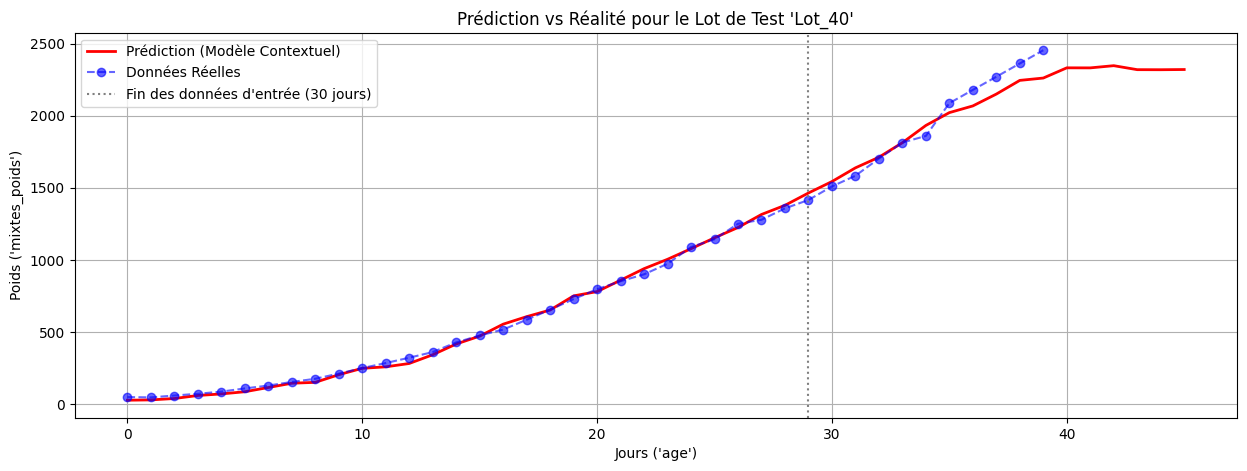

MAE sur l'horizon : 77.78 g | MAPE sur l'horizon : 3.65%

--- Évaluation du Lot : Lot_4 ---


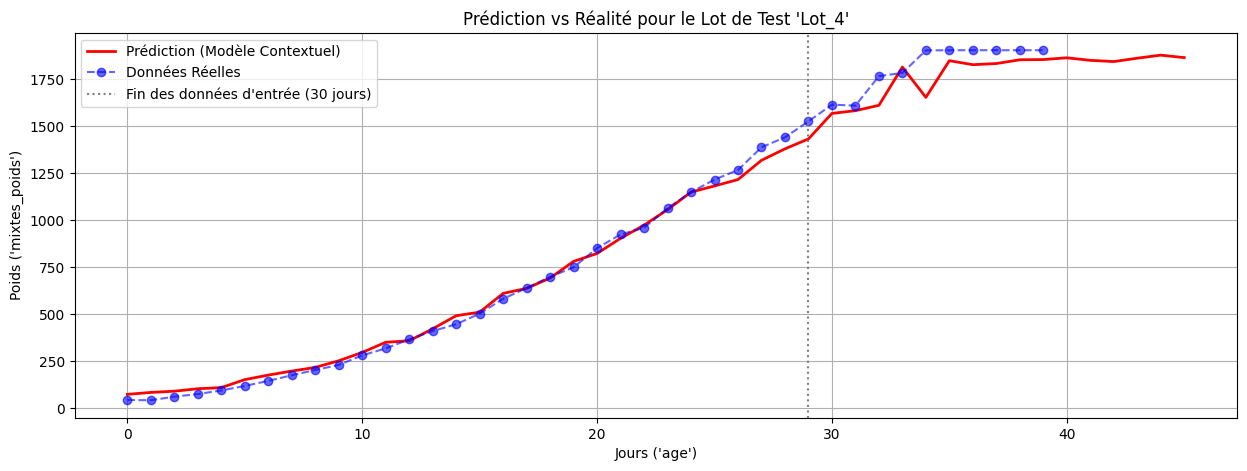

MAE sur l'horizon : 81.47 g | MAPE sur l'horizon : 4.42%

--- Évaluation du Lot : Lot_5 ---


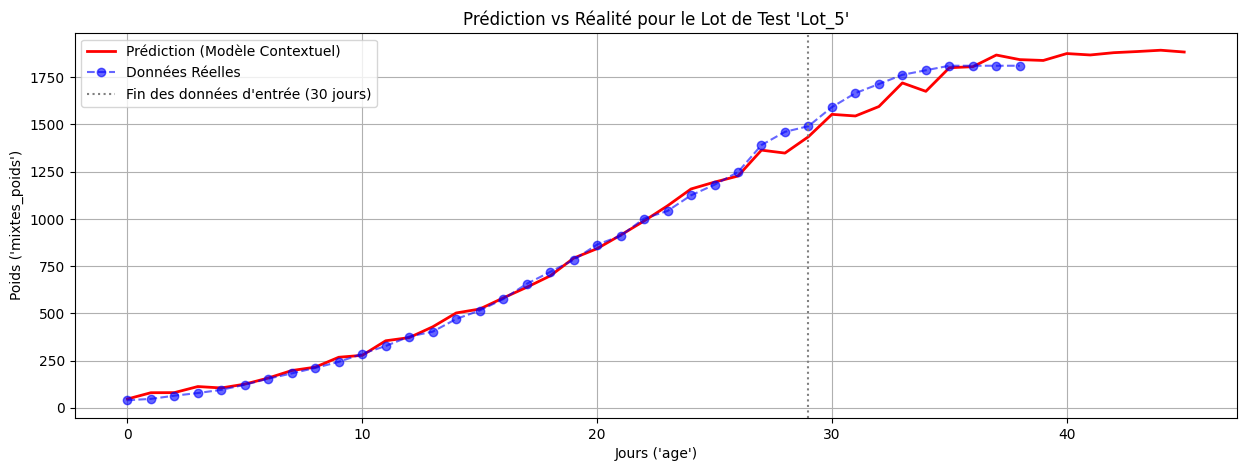

MAE sur l'horizon : 59.74 g | MAPE sur l'horizon : 3.45%

--- Évaluation du Lot : Lot_21 ---


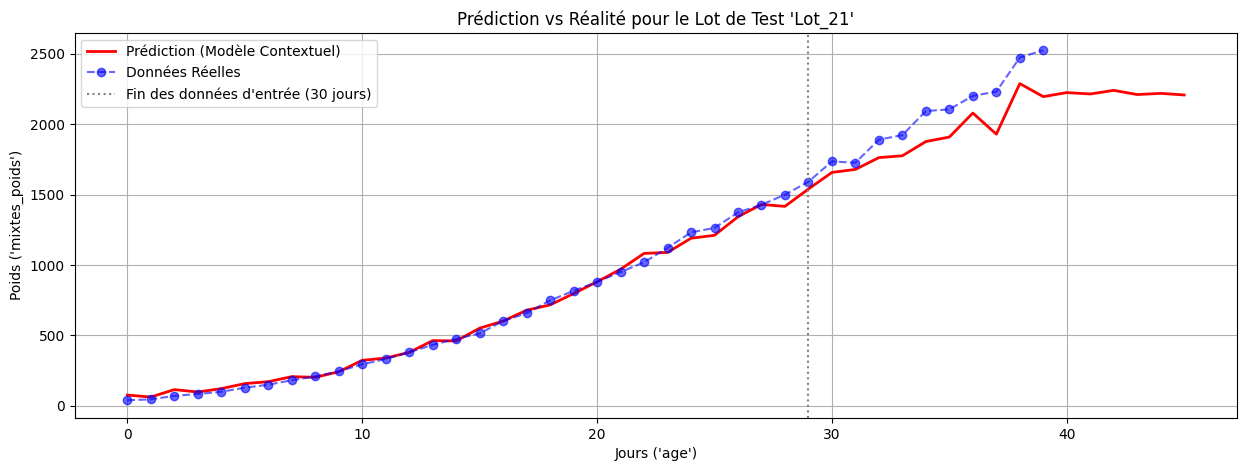

MAE sur l'horizon : 175.27 g | MAPE sur l'horizon : 8.09%

--- Évaluation du Lot : Lot_45 ---


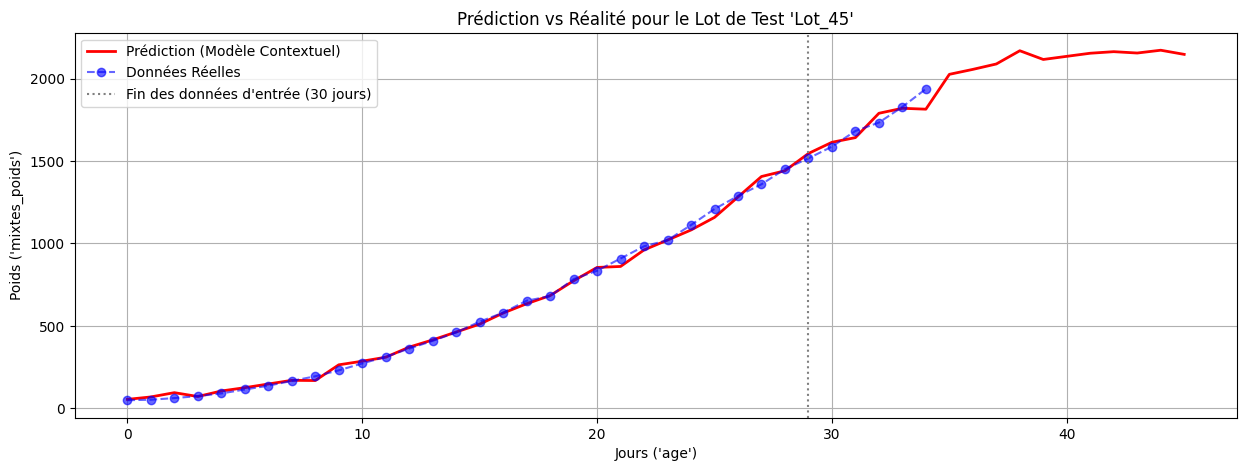

MAE sur l'horizon : 50.88 g | MAPE sur l'horizon : 2.82%


--- RAPPORT D'ÉVALUATION FINAL (MODE INFÉRENCE AVEC HISTORIQUE) ---
Nombre de lots de test évalués : 5
MAE Moyenne  : 89.03 g
MAPE Moyenne : 4.49 %

Les prédictions du modèle AVEC contexte ont été sauvegardées dans : /kaggle/working/predictions_avec_contexte.pkl


In [25]:
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import torch
import pickle
import numpy as np
import os
import pandas as pd

# ===================================================================
# ÉVALUATION  DU MODÈLE AUGMENTÉ (LOTS COURTS)
# ===================================================================

# --- 1. Chargement du modèle sauvegardé ---
# à changer le PATH 
MODEL_PATH = '/kaggle/input/timeflow_cycle_court_dur_de_vie/pytorch/default/1/mon_modele_augmente_cycle_court.pt'
if not os.path.exists(MODEL_PATH):
    raise FileNotFoundError(f"Fichier modèle {MODEL_PATH} non trouvé : {MODEL_PATH}")

checkpoint = torch.load(MODEL_PATH, map_location=torch.device('cpu'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Reconstruction du modèle et chargement des poids
augmented_model = AugmentedTimeFlow(
    config=config, 
    encodeur_couvoir=encodeur_couvoir, 
    encodeur_eleveur=encodeur_eleveur,
    encodeur_meteo=encodeur_meteo, 
    encodeur_alim=encodeur_alim, 
    encodeur_duree=encodeur_duree, 
    device=device
).to(device)
augmented_model.load_state_dict(checkpoint['augmented_model_state_dict'])
augmented_model.eval()
print("Modèle augmenté (lots courts) chargé avec succès.\n")

# --- 2. Boucle d'évaluation sur le dataset de test ---
all_mae_scores = []
all_mape_scores = []  # Métrique MAPE
look_back_points = config['data']['look_back_window']
longueur_sequence = config['data']['total_days']
predictions_avec_contexte = {}

for i in range(len(test_dataset)):
    batch_pour_inference = test_dataset[i]
    id_lot_a_tester = test_dataset.lot_ids[i]
    print(f"--- Évaluation du Lot : {id_lot_a_tester} ---")
    
    # Ajout d'une dimension batch pour compatibilité avec le modèle
    for key, value in batch_pour_inference.items():
        batch_pour_inference[key] = value.unsqueeze(0)

    # --- Inférence ---
    prediction_norm_full = augmented_model.predict(batch_pour_inference).cpu().numpy()

    # --- Dénormalisation et visualisation ---
    df_brut_original = X_all[X_all['Lot_ID'] == id_lot_a_tester]
    prediction_poids = (prediction_norm_full * scaler_global['std']) + scaler_global['mean']
    predictions_avec_contexte[id_lot_a_tester] = prediction_poids
    jours_predits = np.arange(longueur_sequence)
    jour_fin_entree = look_back_points
    
    # Visualisation de la prédiction vs données réelles
    plt.figure(figsize=(15, 5))
    plt.plot(jours_predits, prediction_poids, label="Prédiction (Modèle Contextuel)", color='red', linewidth=2)
    plt.plot(df_brut_original['age'], df_brut_original['mixtes_poids'], 'o--', label="Données Réelles", color='blue', alpha=0.6)
    plt.axvline(x=jour_fin_entree - 1, color='gray', linestyle=':', label=f'Fin des données d\'entrée ({jour_fin_entree} jours)')
    plt.title(f"Prédiction vs Réalité pour le Lot de Test '{id_lot_a_tester}'")
    plt.xlabel("Jours ('age')")
    plt.ylabel("Poids ('mixtes_poids')")
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Calcul des métriques (MAE et MAPE) ---
    df_pred = pd.DataFrame({'age': jours_predits, 'poids_predit': prediction_poids})
    df_reel_horizon = df_brut_original[df_brut_original['age'] >= jour_fin_entree]
    
    if not df_reel_horizon.empty:
        df_reel_horizon = df_reel_horizon.copy()
        df_reel_horizon['age'] = df_reel_horizon['age'].astype(int)
        df_pred['age'] = df_pred['age'].round().astype(int)
        
        # Merge pour comparer les valeurs réelles et prédites par jour
        df_compare = pd.merge_asof(df_reel_horizon.sort_values('age'), df_pred.sort_values('age'), on='age')
        df_compare.dropna(inplace=True)
        
        if not df_compare.empty:
            y_true = df_compare['mixtes_poids'].values
            y_pred = df_compare['poids_predit'].values
            
            # Calcul MAE
            mae_error = mae(y_true, y_pred)
            all_mae_scores.append(mae_error)
            
            # Calcul MAPE (%) — robuste aux valeurs proches de zéro
            eps = 1e-8
            denom = np.maximum(np.abs(y_true), eps)
            mape_error = np.mean(np.abs(y_pred - y_true) / denom) * 100.0
            all_mape_scores.append(mape_error)
            
            print(f"MAE sur l'horizon : {mae_error:.2f} g | MAPE sur l'horizon : {mape_error:.2f}%\n")

# --- Rapport final ---
if all_mae_scores:
    print("\n--- RAPPORT D'ÉVALUATION FINAL ---")
    print(f"Nombre de lots de test évalués : {len(all_mae_scores)}")
    print(f"MAE Moyenne  : {np.mean(all_mae_scores):.2f} g")
    print(f"MAPE Moyenne : {np.mean(all_mape_scores):.2f} %")

# --- Sauvegarde des prédictions pour analyse ultérieure ---
DOSSIER_SAUVEGARDE = '/kaggle/working/'
NOM_FICHIER = 'predictions_avec_contexte.pkl'
PATH_SAUVEGARDE_SC = os.path.join(DOSSIER_SAUVEGARDE, NOM_FICHIER)

with open(PATH_SAUVEGARDE_SC, 'wb') as f:
    pickle.dump(predictions_avec_contexte, f)

print(f"\nLes prédictions du modèle AVEC contexte ont été sauvegardées dans : {PATH_SAUVEGARDE_SC}")


---

# Modéle Simulation à Froid 

In [26]:
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader

# ===================================================================
# ENTRAÎNEMENT DE modele Simulation à Froid (LOTS COURTS)
# ===================================================================

print("--- Création du jeu de données pour l'Oracle XGBoost ---")

# --- a) Préparer le DataLoader SANS mélange pour extraire les Z_residu ---
train_dataset_ordered = PouletSimpleDataset(
    lot_ids=train_lot_ids,
    df_meta=df_meta,
    matrice_poids=donnees_normalisees_train,
    matrice_alim=matrice_alim_paddee_train,
    lot_ids_alim=lot_ids_avec_alim_train,
    config=config
)
train_loader_ordered = DataLoader(
    train_dataset_ordered, 
    batch_size=config['optim']['batch_size'], 
    shuffle=False
)

# --- b) Extraction des Z_residu à partir du modèle augmenté ---
all_z_residus = []
augmented_model.eval()

for batch_data in tqdm(train_loader_ordered, desc="Extraction des Z_residu"):
    with torch.set_grad_enabled(True):
        device = augmented_model.device
        # Transfert des données sur le device
        for key, value in batch_data.items():
            batch_data[key] = value.to(device)
        
        # Calcul des Z de contexte
        z_contexte = augmented_model._calculer_z_contexte(batch_data)
        coords_p = batch_data['coords_passe']
        poids_p = batch_data['poids_passe']
        
        # Initialisation du Z_residu
        dim_residu = augmented_model.dim_z_residu
        modulations_residu = torch.zeros(poids_p.shape[0], dim_residu, device=device).requires_grad_()
        inner_lr_on_device = augmented_model.inner_lr.to(device)
        
        # Fonction combinant Z_residu et Z_contexte pour passer dans l'INR
        def func_rep_combined(coords, mod_residu):
            z_total = torch.cat([mod_residu, z_contexte], dim=1)
            return augmented_model.inr.modulated_forward(coords, z_total)
        
        # Boucle interne pour optimiser Z_residu
        for step in range(config['optim']['inner_steps'] + 5):
            poids_recon_p = func_rep_combined(coords_p, modulations_residu)
            loss_inner = losses.per_element_mse_fn(poids_recon_p, poids_p.unsqueeze(-1)).mean()
            grad = torch.autograd.grad(loss_inner, modulations_residu, create_graph=False)[0]
            modulations_residu = modulations_residu - inner_lr_on_device * grad
        
        # Récupération du Z_residu final
        z_residu_final = modulations_residu.detach()
    
    all_z_residus.append(z_residu_final.cpu().numpy())

# --- c) Assemblage des Z_residu et préparation du jeu pour XGBoost ---
matrice_z_residus = np.concatenate(all_z_residus, axis=0)
print(f"La dimension du Z_residu extrait pour XGBoost est : {matrice_z_residus.shape[1]}")

# Alignement avec les informations contextuelles
df_xgb_train = df_meta.set_index('Lot_ID').loc[train_dataset_ordered.lot_ids].reset_index()
assert len(df_xgb_train) == len(matrice_z_residus)

# --- d) Entraînement de l'oracle XGBoost ---
print("\n--- Entraînement de l'Oracle XGBoost ---")
features_contextuelles = [
    'couvoir_id', 'eleveur_id', 'duree_de_vie', 
    'temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j'
]
X_train_xgb = df_xgb_train[features_contextuelles]
Y_train_xgb = matrice_z_residus

oracle_xgb = MultiOutputRegressor(xgb.XGBRegressor(objective='reg:squarederror'))
oracle_xgb.fit(X_train_xgb, Y_train_xgb)

print("\nModèle 'Oracle' (XGBoost) entraîné avec succès.")


--- Création du jeu de données pour l'Oracle XGBoost ---
--- Initialisation du PouletSimpleDataset ---


/tmp/ipykernel_36/1237003647.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.matrice_alim = torch.tensor(matrice_alim, dtype=torch.float32)


Extraction des Z_residu:   0%|          | 0/11 [00:00<?, ?it/s]

La dimension du Z_residu extrait pour XGBoost est : 36

--- Entraînement de l'Oracle XGBoost ---

Modèle 'Oracle' (XGBoost) ré-entraîné avec la bonne dimension.


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import r2_score
import numpy as np

# ==========================================================
# CELLULE : ENTRAÎNEMENT DU PRÉDICTEUR DE DURÉE DE VIE necessaire pour le pipeline
# ==========================================================

print("--- Entraînement du modèle pour prédire la durée de vie ---")

# --- 1. Préparation des données ---
# df_meta contient déjà les IDs numériques pour les catégories
features = ['couvoir_id', 'eleveur_id']  # Variables explicatives
target = 'duree_de_vie'                  # Variable cible

X = df_meta[features]
y = df_meta[target]

# Petite séparation train/test pour évaluer le modèle
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 2. Définition des features enrichies pour le modèle ---
features_enrichies = ['couvoir_id', 'eleveur_id']  # Possibilité d'ajouter d'autres variables plus tard

# --- 3. Entraînement du modèle XGBoost ---
duree_de_vie_predictor = XGBRegressor(
    n_estimators=100, 
    learning_rate=0.1, 
    random_state=42,
    objective='reg:squarederror'
)
duree_de_vie_predictor.fit(X_train[features_enrichies], y_train)

# --- 4. Évaluation des performances ---
y_pred = duree_de_vie_predictor.predict(X_test)
y_pred_arrondi = np.round(y_pred)  # Optionnel : arrondir les prédictions

# Score R² pour mesurer la qualité des prédictions
score_arrondi = r2_score(y_test, y_pred)
print(f"Performance du modèle pour la prédiction de durée de vie (R²) : {score_arrondi:.2f}")


In [27]:
import torch.nn.functional as F
# ==========================================================
# CELLULE 2 : LA FONCTION DE SIMULATION "WHAT-IF" (FINALE ET ROBUSTE)
# ==========================================================
couvoir_uniques = df_meta['Couvoir_harmonise'].unique().tolist()
eleveur_uniques = df_meta['Eleveur_ID'].unique().tolist()

couvoir_to_id = {c: i for i, c in enumerate(couvoir_uniques)}
eleveur_to_id = {e: i for i, e in enumerate(eleveur_uniques)}

def simuler_courbe_what_if(scenario_df, augmented_model_trained, scaler_global, duree_de_vie_predictor, oracle_xgb):
    """
    Prend un DataFrame d'une ligne décrivant un scénario, et retourne
    la courbe de croissance prédite pour un cycle court.
    """
    augmented_model_trained.eval()
    device = augmented_model_trained.device
    
    # On récupère la VRAIE configuration du modèle entraîné
    config_du_modele = augmented_model_trained.config
    
    # --- 1. Préparer les entrées pour les prédicteurs ---
    # On utilise les mappings globaux qui ont été créés avant l'entraînement
    scenario_df['couvoir_id'] = scenario_df['Couvoir_harmonise'].map(couvoir_to_id)
    scenario_df['eleveur_id'] = scenario_df['Eleveur_ID'].map(eleveur_to_id)
    scenario_df.fillna({'couvoir_id': 0, 'eleveur_id': 0}, inplace=True)
    scenario_df['couvoir_id'] = scenario_df['couvoir_id'].astype(int)
    scenario_df['eleveur_id'] = scenario_df['eleveur_id'].astype(int)

    # --- 2. Prédire la durée de vie ---
    duree_predite = duree_de_vie_predictor.predict(scenario_df[['couvoir_id', 'eleveur_id']])[0]
    duree_predite = int(round(duree_predite))
    scenario_df['duree_de_vie'] = duree_predite
    
    # --- 3. Prédire le Z_residu avec l'Oracle XGBoost ---
    features_pour_oracle = ['couvoir_id', 'eleveur_id', 'duree_de_vie', 
                              'temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j']
    z_residu_predit = oracle_xgb.predict(scenario_df[features_pour_oracle])
    z_residu_tensor = torch.tensor(z_residu_predit, dtype=torch.float32).to(device)

    # --- 4. Calculer les Z de contexte avec les encodeurs de TimeFlow ---
    with torch.no_grad():
        id_couvoir_tensor = torch.tensor(scenario_df['couvoir_id'].values, dtype=torch.long).to(device)
        z_couvoir = augmented_model_trained.encodeur_couvoir(id_couvoir_tensor)

        id_eleveur_tensor = torch.tensor(scenario_df['eleveur_id'].values, dtype=torch.long).to(device)
        z_eleveur = augmented_model_trained.encodeur_eleveur(id_eleveur_tensor)
        
        meteo_tensor = torch.tensor(scenario_df[['temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j']].values, dtype=torch.float32).to(device)
        z_meteo = augmented_model_trained.encodeur_meteo(meteo_tensor)
        
        # Pour Z_alim, on utilise la config du modèle pour être sûr
        longueur_max_alim = matrice_alim_paddee_train.shape[1] # Avoir cette variable disponible
        serie_alim_dummy = torch.zeros(1, longueur_max_alim, config_du_modele['lstm']['input_dim_alim']).to(device)
        z_alim = augmented_model_trained.encodeur_alim(serie_alim_dummy)

    # --- 5. Assembler le Z_total ---
    z_contexte = torch.cat([z_couvoir, z_eleveur, z_meteo, z_alim], dim=1)
     # --- DÉBOGAGE : On imprime toutes les dimensions ---
    print("\n--- DÉBOGAGE DES DIMENSIONS ---")
    print(f"Shape de z_residu_predit (Oracle) : {z_residu_predit.shape}")
    print(f"Shape de z_couvoir        : {z_couvoir.shape}")
    print(f"Shape de z_eleveur        : {z_eleveur.shape}")
    print(f"Shape de z_meteo          : {z_meteo.shape}")
    print(f"Shape de z_alim           : {z_alim.shape}")
    print(f"Total Contexte            : {z_contexte.shape[1]}")
    print(f"Total Résidu              : {z_residu_tensor.shape[1]}")
    z_total_simule = torch.cat([z_residu_tensor, z_contexte], dim=1)
    print(f"Shape finale de z_total_simule : {z_total_simule.shape}")
    print("---------------------------------")
    
    # --- CORRECTION ET VÉRIFICATION DE LA DIMENSION ---
    taille_attendue = config_du_modele['inr']['latent_dim']
    taille_calculee = z_total_simule.shape[1]
    
    taille_attendue = config_du_modele['inr']['latent_dim']
    taille_calculee = z_total_simule.shape[1]

    if taille_calculee != taille_attendue:
        print(f"AVERTISSEMENT DE DIMENSION : Z_total calculé a une taille de {taille_calculee}, "
              f"mais le modèle attend {taille_attendue}. Ajustement en cours...")
        
        # S'il est trop petit, on ajoute des zéros (padding)
        if taille_calculee < taille_attendue:
            padding_needed = taille_attendue - taille_calculee
            # F.pad attend (batch, padding_gauche, padding_droit)
            z_total_simule = F.pad(z_total_simule, (0, padding_needed))
        
        # S'il est trop grand, on le coupe (tronquage)
        else:
            z_total_simule = z_total_simule[:, :taille_attendue]
            
        print(f"Nouvelle shape de z_total_simule : {z_total_simule.shape}")
    
    # --- 6. Générer la courbe avec le COEUR de TimeFlow ---
    with torch.no_grad():
        longueur_sequence = config_du_modele['data']['total_days']
        grid_t = torch.linspace(0, longueur_sequence - 1, longueur_sequence).unsqueeze(-1).unsqueeze(0).to(device)
        
        prediction_norm = augmented_model_trained.inr.modulated_forward(grid_t, z_total_simule)
        prediction_norm = prediction_norm.squeeze().cpu().numpy()
        
    # --- 7. Dénormaliser avec le bon scaler ---
    prediction_poids = (prediction_norm * scaler_global['std']) + scaler_global['mean']
    
    return prediction_poids, duree_predite

--- Création du Scénario 1 : Conditions Normales ---
  Couvoir_harmonise   Eleveur_ID  temp_int_moy_j  hygro_int_moy_j  \
0          goasduff  606-448-428       26.372557        54.750872   

   temp_ext_moy_j  
0       15.132743  

--- Création du Scénario 2 : Conditions Chaudes et Sèches ---
  Couvoir_harmonise   Eleveur_ID  temp_int_moy_j  hygro_int_moy_j  \
0          goasduff  606-448-428       28.372557        44.750872   

   temp_ext_moy_j  
0       17.132743  

--- Création du Scénario 3 : Conditions Froides et Humides ---
  Couvoir_harmonise   Eleveur_ID  temp_int_moy_j  hygro_int_moy_j  \
0          goasduff  606-448-428       25.372557        59.750872   

   temp_ext_moy_j  
0       14.132743  

--- Lancement des simulations ---

--- DÉBOGAGE DES DIMENSIONS ---
Shape de z_residu_predit (Oracle) : (1, 36)
Shape de z_couvoir        : torch.Size([1, 4])
Shape de z_eleveur        : torch.Size([1, 4])
Shape de z_meteo          : torch.Size([1, 8])
Shape de z_alim           : to

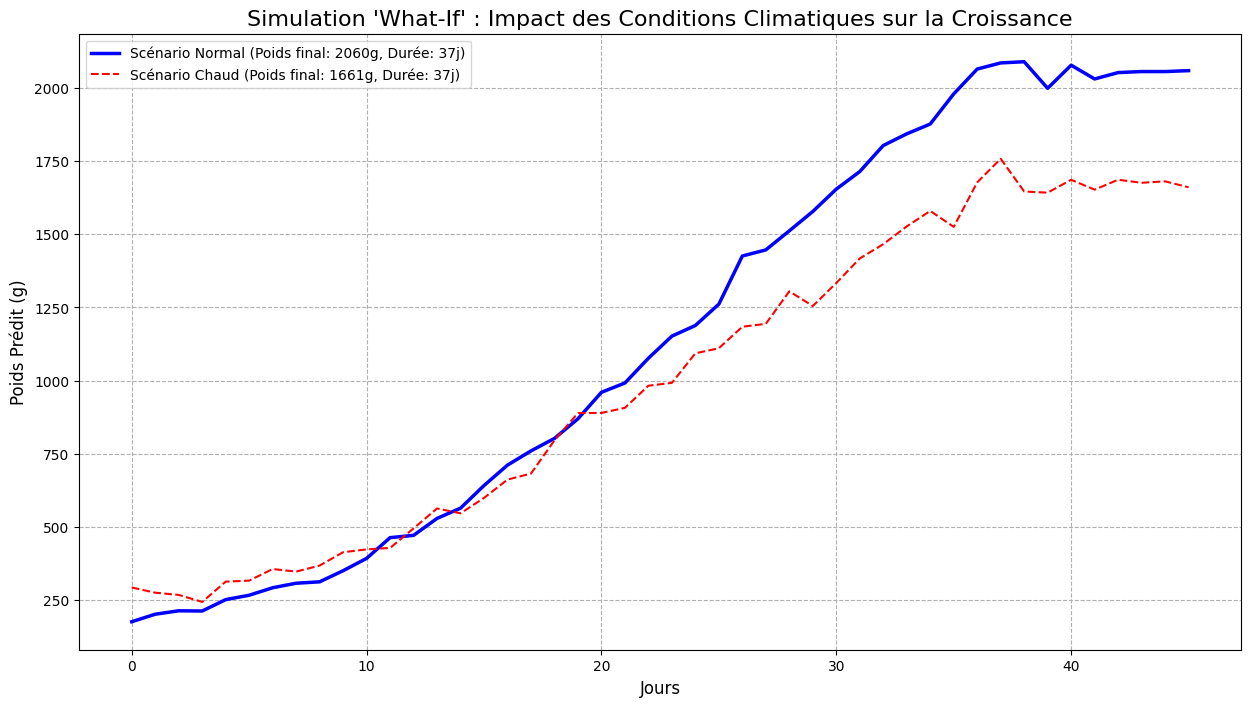

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ==========================================================
# CELLULE 3 : LANCEMENT DES SIMULATIONS (AVEC SCÉNARIO FROID)
# ==========================================================


# --- Scénario 1 : Conditions "Normales" (notre baseline) ---
print("--- Création du Scénario 1 : Conditions Normales ---")
scenario_normal = {
    'Couvoir_harmonise': [df_meta['Couvoir_harmonise'].mode()[0]],
    'Eleveur_ID': [df_meta['Eleveur_ID'].mode()[0]],
    'temp_int_moy_j': [df_meta['temp_int_moy_j'].mean()],
    'hygro_int_moy_j': [df_meta['hygro_int_moy_j'].mean()],
    'temp_ext_moy_j': [df_meta['temp_ext_moy_j'].mean()],
}
df_normal = pd.DataFrame(scenario_normal)
print(df_normal)

# --- Scénario 2 : Conditions "Chaudes et Sèches" ---
print("\n--- Création du Scénario 2 : Conditions Chaudes et Sèches ---")
scenario_chaud = {
    'Couvoir_harmonise': [df_meta['Couvoir_harmonise'].mode()[0]],
    'Eleveur_ID': [df_meta['Eleveur_ID'].mode()[0]],
    'temp_int_moy_j': [df_meta['temp_int_moy_j'].mean() + 2], # On augmente la temp de 2 degrés
    'hygro_int_moy_j': [df_meta['hygro_int_moy_j'].mean() - 10],# On baisse l'hygro de 10%
    'temp_ext_moy_j': [df_meta['temp_ext_moy_j'].mean() + 2],
}
df_chaud = pd.DataFrame(scenario_chaud)
print(df_chaud)

# --- NOUVEAU : Scénario 3 : Conditions "Froides et Humides" ---
print("\n--- Création du Scénario 3 : Conditions Froides et Humides ---")
scenario_froid = {
    'Couvoir_harmonise': [df_meta['Couvoir_harmonise'].mode()[0]],
    'Eleveur_ID': [df_meta['Eleveur_ID'].mode()[0]],
    'temp_int_moy_j': [df_meta['temp_int_moy_j'].mean() - 1], # On baisse la temp de 2 degrés
    'hygro_int_moy_j': [df_meta['hygro_int_moy_j'].mean() + 5],# On augmente l'hygro de 10%
    'temp_ext_moy_j': [df_meta['temp_ext_moy_j'].mean() - 1],
}
df_froid = pd.DataFrame(scenario_froid)
print(df_froid)

# --- Lancer les trois simulations ---
print("\n--- Lancement des simulations ---")
courbe_normale, duree_normale = simuler_courbe_what_if(df_normal, augmented_model, scaler_global, duree_de_vie_predictor, oracle_xgb)
print("Simulation 'Normale' terminée.")
courbe_chaude, duree_chaude = simuler_courbe_what_if(df_chaud, augmented_model, scaler_global, duree_de_vie_predictor, oracle_xgb)
print("Simulation 'Chaude' terminée.")
courbe_froide, duree_froide = simuler_courbe_what_if(df_froid, augmented_model, scaler_global, duree_de_vie_predictor, oracle_xgb)
print("Simulation 'Froide' terminée.")

# --- Visualiser la comparaison des trois scénarios ---
print("\n--- Génération du graphique de comparaison ---")
plt.figure(figsize=(15, 8))

jours = np.arange(config['data']['total_days'])

plt.plot(jours, courbe_normale, label=f"Scénario Normal (Poids final: {courbe_normale[-1]:.0f}g, Durée: {duree_normale}j)", linewidth=2.5, color='blue')
plt.plot(jours, courbe_chaude, label=f"Scénario Chaud (Poids final: {courbe_chaude[-1]:.0f}g, Durée: {duree_chaude}j)", linestyle='--', color='red')
#plt.plot(jours, courbe_froide, label=f"Scénario Froid (Poids final: {courbe_froide[-1]:.0f}g, Durée: {duree_froide}j)", linestyle=':', color='green')

plt.title("Simulation 'What-If' : Impact des Conditions Climatiques sur la Croissance", fontsize=16)
plt.xlabel("Jours", fontsize=12)
plt.ylabel("Poids Prédit (g)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--')
plt.show()

---

## ÉVALUATION QUANTITATIVE ET QUALITATIVE DU PIPELINE DE SIMULATION À FROID

In [30]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from sklearn.metrics import mean_absolute_error

# ===================================================================
# ÉVALUATION QUANTITATIVE ET QUALITATIVE DU PIPELINE DE SIMULATION À FROID
# ===================================================================

# --- 1. Initialisation ---
all_mae_scores_simulation = []
all_mape_scores_simulation = []
rows_scores = []  # pour construire le tableau final (par lot)

print("--- Début de l'évaluation du pipeline de simulation à froid sur le jeu de test ---")

# --- 2. Boucle d'évaluation sur chaque lot de test ---
for lot_id in test_lot_ids:
    
    # a) Métadonnées du lot
    df_lot_meta = df_meta[df_meta['Lot_ID'] == lot_id].copy()
    if df_lot_meta.empty:
        print(f"AVERTISSEMENT : Lot {lot_id} non trouvé dans df_meta. Ignoré.")
        continue
        
    scenario_lot = df_lot_meta[['Couvoir_harmonise', 'Eleveur_ID', 'duree_de_vie', 
                                'temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j']]
    
    # b) Simulation "à froid"
    courbe_predite_froid, _ = simuler_courbe_what_if(
        scenario_lot, 
        augmented_model, 
        scaler_global,
        duree_de_vie_predictor,
        oracle_xgb
    )
    
    # c) Courbe réelle
    df_reel = X_all[X_all['Lot_ID'] == lot_id].sort_values(by='age')
    poids_reels = df_reel['mixtes_poids'].values
    jours_reels = df_reel['age'].values
    longueur_reelle = len(poids_reels)
    if longueur_reelle == 0:
        print(f"AVERTISSEMENT : Aucune donnée réelle pour le lot {lot_id}. Ignoré.")
        continue

    # d) Métriques (MAE + MAPE)
    prediction_alignee = courbe_predite_froid[:longueur_reelle]
    
    mae_error = mean_absolute_error(poids_reels, prediction_alignee)
    all_mae_scores_simulation.append(mae_error)
    
    # MAPE (%) robuste aux zéros
    eps = 1e-8
    denom = np.maximum(np.abs(poids_reels), eps)
    mape_error = np.mean(np.abs(prediction_alignee - poids_reels) / denom) * 100.0
    all_mape_scores_simulation.append(mape_error)
    
    rows_scores.append({
        "Lot_ID": lot_id,
        "MAE_g": mae_error,
        "MAPE_%": mape_error
    })
    
    print(f"Lot {lot_id} -> MAE: {mae_error:.2f} g | MAPE: {mape_error:.2f}%")

    # e) Graphique interactif (inchangé)
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=jours_reels, y=poids_reels, mode='lines+markers',
        name='Poids Réel (Vérité Terrain)', line=dict(color='blue', width=2), marker=dict(size=5)
    ))
    jours_predits = np.arange(len(courbe_predite_froid))
    fig.add_trace(go.Scatter(
        x=jours_predits, y=courbe_predite_froid, mode='lines',
        name='Prédiction à Froid (avec Oracle XGBoost)', line=dict(color='red', width=2.5, dash='dash')
    ))
    fig.update_layout(
        title=f"Évaluation de la Simulation à Froid pour le Lot : {lot_id}",
        xaxis_title="Âge du lot (jours)",
        yaxis_title="Poids (grammes)",
        legend_title="Courbes",
        template="plotly_white",
        hovermode="x unified",
        width=1000, height=500
    )
    fig.show()

# --- 3. Tableau des scores + Rapport Final ---
if all_mae_scores_simulation:
    # Tableau pandas
    df_scores = pd.DataFrame(rows_scores).sort_values("Lot_ID").reset_index(drop=True)
    print("\n=== Tableau des scores par lot ===")
    print(df_scores)

    # Table Plotly (optionnel, pour un rendu propre en notebook)
    fig_table = go.Figure(data=[go.Table(
        header=dict(values=list(df_scores.columns), fill_color='lightgrey', align='center'),
        cells=dict(values=[df_scores[c] for c in df_scores.columns], align='center')
    )])
    fig_table.update_layout(title="Scores par lot (MAE, MAPE)")
    fig_table.show()

    # Statistiques globales
    mae_moyenne = df_scores["MAE_g"].mean()
    mape_moyenne = df_scores["MAPE_%"].mean()
    mae_mediane = df_scores["MAE_g"].median()
    mape_mediane = df_scores["MAPE_%"].median()

    print("\n" + "="*50)
    print("--- RAPPORT D'ÉVALUATION FINAL DU PIPELINE DE SIMULATION À FROID ---")
    print(f"Nombre de lots de test évalués : {len(df_scores)}")
    print(f"MAE Moyenne   : {mae_moyenne:.2f} g | Médiane : {mae_mediane:.2f} g")
    print(f"MAPE Moyenne  : {mape_moyenne:.2f}% | Médiane : {mape_mediane:.2f}%")
    print("="*50)

    # Sauvegarde du tableau
    # (décommente et ajuste le chemin si besoin)
    # df_scores.to_csv("scores_simulation_froid.csv", index=False)
else:
    print("\nAucune évaluation n'a pu être effectuée. Vérifiez votre jeu de test.")


--- Début de l'évaluation du pipeline de simulation à froid sur le jeu de test ---

--- DÉBOGAGE DES DIMENSIONS ---
Shape de z_residu_predit (Oracle) : (1, 36)
Shape de z_couvoir        : torch.Size([1, 4])
Shape de z_eleveur        : torch.Size([1, 4])
Shape de z_meteo          : torch.Size([1, 8])
Shape de z_alim           : torch.Size([1, 8])
Total Contexte            : 24
Total Résidu              : 36
Shape finale de z_total_simule : torch.Size([1, 60])
---------------------------------
AVERTISSEMENT DE DIMENSION : Z_total calculé a une taille de 60, mais le modèle attend 64. Ajustement en cours...
Nouvelle shape de z_total_simule : torch.Size([1, 64])
Lot Lot_40 -> MAE: 136.83 g | MAPE: 54.40%


/tmp/ipykernel_36/538243875.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenario_df['couvoir_id'] = scenario_df['Couvoir_harmonise'].map(couvoir_to_id)
/tmp/ipykernel_36/538243875.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  scenario_df['eleveur_id'] = scenario_df['Eleveur_ID'].map(eleveur_to_id)
/tmp/ipykernel_36/538243875.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas


--- DÉBOGAGE DES DIMENSIONS ---
Shape de z_residu_predit (Oracle) : (1, 36)
Shape de z_couvoir        : torch.Size([1, 4])
Shape de z_eleveur        : torch.Size([1, 4])
Shape de z_meteo          : torch.Size([1, 8])
Shape de z_alim           : torch.Size([1, 8])
Total Contexte            : 24
Total Résidu              : 36
Shape finale de z_total_simule : torch.Size([1, 60])
---------------------------------
AVERTISSEMENT DE DIMENSION : Z_total calculé a une taille de 60, mais le modèle attend 64. Ajustement en cours...
Nouvelle shape de z_total_simule : torch.Size([1, 64])
Lot Lot_4 -> MAE: 85.93 g | MAPE: 9.78%


/tmp/ipykernel_36/538243875.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:27: SettingWithCopyWarning:


A value is trying to 


--- DÉBOGAGE DES DIMENSIONS ---
Shape de z_residu_predit (Oracle) : (1, 36)
Shape de z_couvoir        : torch.Size([1, 4])
Shape de z_eleveur        : torch.Size([1, 4])
Shape de z_meteo          : torch.Size([1, 8])
Shape de z_alim           : torch.Size([1, 8])
Total Contexte            : 24
Total Résidu              : 36
Shape finale de z_total_simule : torch.Size([1, 60])
---------------------------------
AVERTISSEMENT DE DIMENSION : Z_total calculé a une taille de 60, mais le modèle attend 64. Ajustement en cours...
Nouvelle shape de z_total_simule : torch.Size([1, 64])
Lot Lot_5 -> MAE: 47.70 g | MAPE: 21.45%


/tmp/ipykernel_36/538243875.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:27: SettingWithCopyWarning:


A value is trying to 

/tmp/ipykernel_36/538243875.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:27: SettingWithCopyWarning:


A value is trying to 


--- DÉBOGAGE DES DIMENSIONS ---
Shape de z_residu_predit (Oracle) : (1, 36)
Shape de z_couvoir        : torch.Size([1, 4])
Shape de z_eleveur        : torch.Size([1, 4])
Shape de z_meteo          : torch.Size([1, 8])
Shape de z_alim           : torch.Size([1, 8])
Total Contexte            : 24
Total Résidu              : 36
Shape finale de z_total_simule : torch.Size([1, 60])
---------------------------------
AVERTISSEMENT DE DIMENSION : Z_total calculé a une taille de 60, mais le modèle attend 64. Ajustement en cours...
Nouvelle shape de z_total_simule : torch.Size([1, 64])
Lot Lot_21 -> MAE: 135.94 g | MAPE: 13.72%


/tmp/ipykernel_36/538243875.py:24: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_36/538243875.py:27: SettingWithCopyWarning:


A value is trying to 


--- DÉBOGAGE DES DIMENSIONS ---
Shape de z_residu_predit (Oracle) : (1, 36)
Shape de z_couvoir        : torch.Size([1, 4])
Shape de z_eleveur        : torch.Size([1, 4])
Shape de z_meteo          : torch.Size([1, 8])
Shape de z_alim           : torch.Size([1, 8])
Total Contexte            : 24
Total Résidu              : 36
Shape finale de z_total_simule : torch.Size([1, 60])
---------------------------------
AVERTISSEMENT DE DIMENSION : Z_total calculé a une taille de 60, mais le modèle attend 64. Ajustement en cours...
Nouvelle shape de z_total_simule : torch.Size([1, 64])
Lot Lot_45 -> MAE: 107.21 g | MAPE: 47.56%



=== Tableau des scores par lot ===
   Lot_ID       MAE_g     MAPE_%
0  Lot_21  135.943997  13.716916
1   Lot_4   85.933119   9.775120
2  Lot_40  136.825175  54.403423
3  Lot_45  107.208883  47.560700
4   Lot_5   47.696921  21.446980



--- RAPPORT D'ÉVALUATION FINAL DU PIPELINE DE SIMULATION À FROID ---
Nombre de lots de test évalués : 5
MAE Moyenne   : 102.72 g | Médiane : 107.21 g
MAPE Moyenne  : 29.38% | Médiane : 21.45%


---

# entrainement Arimax et Prophet 

In [32]:
!pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.1 MB/s eta 0:00:0000:01


In [29]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA




def prepare_simple_features(df: pd.DataFrame):
    """
    Prépare un DataFrame simplifié pour ARIMAX ou Prophet.
    Ne garde que les colonnes alimentation, eau, poids/chaine, et moyennes météo.
    Évite au maximum la suppression de lignes.
    """
    if df.empty:
        return pd.DataFrame()

    df = df.copy()
    df = _rename_duplicate_columns(df)  # Enlève les doublons de colonnes

    # Garder seulement les colonnes nécessaires si elles existent
    keep_cols = ["age", "aliment_kg", "eau_l", "chaine_kg","mixtes_poids" ,
                 "temp_mini", "temp_maxi", "temp_ext_mini", "temp_ext_maxi",
                 "hygro_mini", "hygro_maxi"]

    keep_cols_present = [col for col in keep_cols if col in df.columns]
    df = df[keep_cols_present]

    # Nettoyer les colonnes numériques
    for col in df.columns:
        if col != "age":
            df[col] = _clean_series(df[col])

    # Supprimer uniquement les lignes sans âge
    df.dropna(subset=["age"], inplace=True)
    df["age"] = df["age"].astype(int)

    # Calcul des moyennes internes et externes + hygro
    if {"temp_mini", "temp_maxi"}.issubset(df.columns):
        df["temp_int_moy"] = df[["temp_mini", "temp_maxi"]].mean(axis=1)
    if {"temp_ext_mini", "temp_ext_maxi"}.issubset(df.columns):
        df["temp_ext_moy"] = df[["temp_ext_mini", "temp_ext_maxi"]].mean(axis=1)
    if {"hygro_mini", "hygro_maxi"}.issubset(df.columns):
        df["hygro_moy"] = df[["hygro_mini", "hygro_maxi"]].mean(axis=1)

    # Imputation des NaN par interpolation linéaire puis médiane si nécessaire
    df.interpolate(method="linear", limit_direction="both", inplace=True)
    for col in df.columns:
        if df[col].isna().any():
            df[col].fillna(df[col].median(), inplace=True)

    return df.reset_index(drop=True)


In [30]:
X_all_exo, lot_ids_exo = [], []

# On boucle sur les DataFrames filtrés et validés
for lot_name, df_lot in zip(lots_valides, donnees_lots_valides):
    
    # Préparation des features simples
    X_lot_exo = prepare_simple_features(df_lot)

    # On saute si vide
    if X_lot_exo.empty:
        continue

    # Ajout de l'ID du lot
    X_lot_exo["Lot_ID"] = lot_name
    X_all_exo.append(X_lot_exo)
    lot_ids_exo.extend([lot_name] * len(X_lot_exo))

# Concaténation finale
X_all_exo = pd.concat(X_all_exo, ignore_index=True)

# Conversion de age en int si présent
if 'age' in X_all_exo.columns:
    X_all_exo['age'] = X_all_exo['age'].astype(int)

print("X_all_exo :", X_all_exo.shape)


/tmp/ipykernel_36/2078287292.py:51: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.



/tmp/ipykernel_36/2078287292.py:51: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or d

X_all_exo : (1862, 14)


In [33]:
import pandas as pd
import torch
import numpy as np
import plotly.graph_objects as go
from prophet import Prophet
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import warnings

# --- Ignorer les warnings pour une sortie propre ---
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', UserWarning)
import logging
logging.getLogger('cmdstanpy').setLevel(logging.ERROR)

# ===================================================================
# COMPARAISON: TIMEFLOW CONTEXTUEL vs. BASELINES (COURBES COMPLÈTES)
# ===================================================================

# --- 1. Configuration ---
# On suppose que les variables nécessaires sont chargées.

data_complet = X_all_exo
lots_test_cibles = ["Lot_45", "Lot_21", "Lot_5", "Lot_4", "Lot_40"]

variables_exogenes = ['aliment_kg', 'eau_l', 'temp_int_moy', 'temp_ext_moy', 'hygro_moy']
JOUR_DE_CESURE = 30

results = []

print(f"Lancement de la comparaison sur {len(lots_test_cibles)} lots avec un historique de {JOUR_DE_CESURE} jours...")

# --- 2. Boucle d'évaluation sur les lots cibles ---
for lot_id in tqdm(lots_test_cibles, desc="Comparaison des modèles"):
    
    # --- a) Préparation des données du lot ---
    df_lot = data_complet[data_complet['Lot_ID'] == lot_id].copy().sort_values(by='age').reset_index(drop=True)
    df_train = df_lot[df_lot['age'] <= JOUR_DE_CESURE]
    df_future = df_lot[df_lot['age'] > JOUR_DE_CESURE]
    
    if len(df_future) == 0:
        continue
        
    y_reel_futur = df_future['mixtes_poids'].values
    
    predictions_completes = {}

    # --- b) Modèle 1 : TimeFlow Contextuel ---
    try:
        idx_in_dataset = test_dataset.lot_ids.index(lot_id)
        batch_pour_inference = test_dataset[idx_in_dataset]
        for key, value in batch_pour_inference.items():
            batch_pour_inference[key] = value.unsqueeze(0)

        prediction_norm_full = augmented_model.predict(batch_pour_inference).cpu().numpy()
        prediction_poids_full = (prediction_norm_full * scaler_global['std']) + scaler_global['mean']
        
        predictions_completes['TimeFlow'] = prediction_poids_full[:len(df_lot)]
        
        y_pred_timeflow_horizon = prediction_poids_full[len(df_train):len(df_lot)]
        mae = mean_absolute_error(y_reel_futur, y_pred_timeflow_horizon)
        mape = np.mean(np.abs((y_reel_futur - y_pred_timeflow_horizon) / (y_reel_futur + 1e-8))) * 100
        results.append({'Lot_ID': lot_id, 'Modele': 'TimeFlow', 'MAE': mae, 'MAPE': mape})
    except Exception as e:
        print(f"\nErreur TimeFlow pour le lot {lot_id}: {e}")

    # --- c) Modèle 2 : ARIMAX ---
    try:
        y_train = df_train['mixtes_poids']
        X_train = df_train[variables_exogenes]
        X_future = df_future[variables_exogenes]

        arimax_model = auto_arima(y=y_train, exogenous=X_train, start_p=1, start_q=1, max_p=3, max_q=3, m=1, d=1, seasonal=False, stepwise=True, suppress_warnings=True, error_action='ignore')
        
        y_pred_arimax_horizon = arimax_model.predict(n_periods=len(df_future), exogenous=X_future).to_numpy()
        y_pred_arimax_history = arimax_model.predict_in_sample(exogenous=X_train)
        y_pred_arimax_full = np.concatenate([y_pred_arimax_history, y_pred_arimax_horizon])
        predictions_completes['ARIMAX'] = y_pred_arimax_full
        
        mae = mean_absolute_error(y_reel_futur, y_pred_arimax_horizon)
        mape = np.mean(np.abs((y_reel_futur - y_pred_arimax_horizon) / (y_reel_futur + 1e-8))) * 100
        results.append({'Lot_ID': lot_id, 'Modele': 'ARIMAX', 'MAE': mae, 'MAPE': mape})
    except Exception as e:
        print(f"\nErreur ARIMAX pour le lot {lot_id}: {e}")

    # --- d) Modèle 3 : Prophet ---
    try:
        print(f"--- [DEBUG Prophet Lot {lot_id}] : Début du bloc Prophet.")
        df_prophet_train = df_train[['age', 'mixtes_poids']].rename(columns={'age': 'ds', 'mixtes_poids': 'y'})
        for col in variables_exogenes: df_prophet_train[col] = df_train[col].values
        df_prophet_train['ds'] = pd.to_datetime(df_prophet_train['ds'], unit='D')
            
        prophet_model = Prophet(growth='linear', weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
        for reg in variables_exogenes: prophet_model.add_regressor(reg)
        
        print(f"--- [DEBUG Prophet Lot {lot_id}] : Lancement du .fit()...")
        prophet_model.fit(df_prophet_train)
        print(f"--- [DEBUG Prophet Lot {lot_id}] : .fit() terminé.")

        df_prophet_full = df_lot[['age']].rename(columns={'age': 'ds'})
        for col in variables_exogenes: df_prophet_full[col] = df_lot[col].values
        df_prophet_full['ds'] = pd.to_datetime(df_prophet_full['ds'], unit='D')
        
        print(f"--- [DEBUG Prophet Lot {lot_id}] : Lancement du .predict()...")
        forecast_full = prophet_model.predict(df_prophet_full)
        y_pred_prophet_full = forecast_full['yhat'].values
        print(f"--- [DEBUG Prophet Lot {lot_id}] : Prédiction réussie. Shape: {y_pred_prophet_full.shape}")
        
        predictions_completes['Prophet'] = y_pred_prophet_full
        print(f"--- [DEBUG Prophet Lot {lot_id}] : Prédiction ajoutée au dictionnaire.")

        y_pred_prophet_horizon = y_pred_prophet_full[len(df_train):]
        mae = mean_absolute_error(y_reel_futur, y_pred_prophet_horizon)
        mape = np.mean(np.abs((y_reel_futur - y_pred_prophet_horizon) / (y_reel_futur + 1e-8))) * 100
        results.append({'Lot_ID': lot_id, 'Modele': 'Prophet', 'MAE': mae, 'MAPE': mape})
        
    except Exception as e:
        # On rend l'erreur très visible
        print("\n" + "!"*20)
        print(f"ERREUR CRITIQUE DANS LE BLOC PROPHET pour le lot {lot_id}")
        print(f"L'erreur est : {e}")
        traceback.print_exc() # Imprime la trace complète de l'erreur
        print("!"*20 + "\n")

    # --- e) Tracer le graphique comparatif avec les 4 COURBES COMPLÈTES ---
    fig = go.Figure()

    # 1. Courbe réelle
    fig.add_trace(go.Scatter(x=df_lot['age'], y=df_lot['mixtes_poids'], mode='lines+markers', name='Poids Réel', line=dict(color='black', width=3), marker=dict(size=5)))

    # 2. Prédiction TimeFlow
    if 'TimeFlow' in predictions_completes:
        fig.add_trace(go.Scatter(x=df_lot['age'], y=predictions_completes['TimeFlow'], mode='lines', name='TimeFlow', line=dict(color='red', width=3)))

    # 3. Prédiction ARIMAX
    if 'ARIMAX' in predictions_completes:
        fig.add_trace(go.Scatter(x=df_lot['age'], y=predictions_completes['ARIMAX'], mode='lines', name='ARIMAX', line=dict(color='green', width=2, dash='dash')))
        
    # --- CORRECTION FINALE : La ligne pour tracer Prophet est bien ici ---
    # 4. Prédiction Prophet
    if 'Prophet' in predictions_completes:
        fig.add_trace(go.Scatter(x=df_lot['age'], y=predictions_completes['Prophet'], mode='lines', name='Prophet', line=dict(color='blue', width=2, dash='dot')))


    fig.add_vline(x=JOUR_DE_CESURE, line_width=2, line_dash="dash", line_color="grey", annotation_text="Horizon")
    fig.update_layout(title=f"Ajustement et Prédiction pour le Lot : {lot_id}", xaxis_title="Âge du lot (jours)", yaxis_title="Poids (grammes)", legend_title="Modèles", template="plotly_white", hovermode="x unified", width=1000, height=550)
    fig.show()

# --- 3. Afficher le rapport final ---
if results:
    results_df = pd.DataFrame(results)
    print("\n\n" + "="*60)
    print("--- RÉSULTATS DÉTAILLÉS PAR LOT ET PAR MODÈLE (SUR L'HORIZON) ---")
    print(results_df.round(2))
    print("\n" + "="*60)
    print(f"--- PERFORMANCES MOYENNES SUR L'HORIZON (Jours > {JOUR_DE_CESURE}) ---")
    print(results_df.groupby('Modele')[['MAE', 'MAPE']].mean().round(2))
    print("="*60)

Lancement de la comparaison sur 5 lots avec un historique de 30 jours...


Comparaison des modèles:   0%|          | 0/5 [00:00<?, ?it/s]10:31:35 - cmdstanpy - INFO - Chain [1] start processing


--- [DEBUG Prophet Lot Lot_45] : Début du bloc Prophet.
--- [DEBUG Prophet Lot Lot_45] : Lancement du .fit()...


10:31:35 - cmdstanpy - INFO - Chain [1] done processing


--- [DEBUG Prophet Lot Lot_45] : .fit() terminé.
--- [DEBUG Prophet Lot Lot_45] : Lancement du .predict()...
--- [DEBUG Prophet Lot Lot_45] : Prédiction réussie. Shape: (35,)
--- [DEBUG Prophet Lot Lot_45] : Prédiction ajoutée au dictionnaire.


Comparaison des modèles:  20%|██        | 1/5 [00:03<00:13,  3.38s/it]10:31:37 - cmdstanpy - INFO - Chain [1] start processing


--- [DEBUG Prophet Lot Lot_21] : Début du bloc Prophet.
--- [DEBUG Prophet Lot Lot_21] : Lancement du .fit()...


10:31:37 - cmdstanpy - INFO - Chain [1] done processing


--- [DEBUG Prophet Lot Lot_21] : .fit() terminé.
--- [DEBUG Prophet Lot Lot_21] : Lancement du .predict()...
--- [DEBUG Prophet Lot Lot_21] : Prédiction réussie. Shape: (40,)
--- [DEBUG Prophet Lot Lot_21] : Prédiction ajoutée au dictionnaire.


Comparaison des modèles:  40%|████      | 2/5 [00:05<00:07,  2.38s/it]10:31:40 - cmdstanpy - INFO - Chain [1] start processing
10:31:40 - cmdstanpy - INFO - Chain [1] done processing


--- [DEBUG Prophet Lot Lot_5] : Début du bloc Prophet.
--- [DEBUG Prophet Lot Lot_5] : Lancement du .fit()...
--- [DEBUG Prophet Lot Lot_5] : .fit() terminé.
--- [DEBUG Prophet Lot Lot_5] : Lancement du .predict()...
--- [DEBUG Prophet Lot Lot_5] : Prédiction réussie. Shape: (39,)
--- [DEBUG Prophet Lot Lot_5] : Prédiction ajoutée au dictionnaire.


Comparaison des modèles:  60%|██████    | 3/5 [00:07<00:05,  2.61s/it]10:31:42 - cmdstanpy - INFO - Chain [1] start processing


--- [DEBUG Prophet Lot Lot_4] : Début du bloc Prophet.
--- [DEBUG Prophet Lot Lot_4] : Lancement du .fit()...


10:31:42 - cmdstanpy - INFO - Chain [1] done processing


--- [DEBUG Prophet Lot Lot_4] : .fit() terminé.
--- [DEBUG Prophet Lot Lot_4] : Lancement du .predict()...
--- [DEBUG Prophet Lot Lot_4] : Prédiction réussie. Shape: (40,)
--- [DEBUG Prophet Lot Lot_4] : Prédiction ajoutée au dictionnaire.


Comparaison des modèles:  80%|████████  | 4/5 [00:10<00:02,  2.52s/it]10:31:43 - cmdstanpy - INFO - Chain [1] start processing
10:31:44 - cmdstanpy - INFO - Chain [1] done processing


--- [DEBUG Prophet Lot Lot_40] : Début du bloc Prophet.
--- [DEBUG Prophet Lot Lot_40] : Lancement du .fit()...
--- [DEBUG Prophet Lot Lot_40] : .fit() terminé.
--- [DEBUG Prophet Lot Lot_40] : Lancement du .predict()...
--- [DEBUG Prophet Lot Lot_40] : Prédiction réussie. Shape: (40,)
--- [DEBUG Prophet Lot Lot_40] : Prédiction ajoutée au dictionnaire.


Comparaison des modèles: 100%|██████████| 5/5 [00:11<00:00,  2.34s/it]



--- RÉSULTATS DÉTAILLÉS PAR LOT ET PAR MODÈLE (SUR L'HORIZON) ---
    Lot_ID    Modele     MAE   MAPE
0   Lot_45  TimeFlow   56.98   3.11
1   Lot_45    ARIMAX   31.08   1.67
2   Lot_45   Prophet   18.35   1.00
3   Lot_21  TimeFlow  186.08   8.49
4   Lot_21    ARIMAX   93.73   4.47
5   Lot_21   Prophet   54.67   2.62
6    Lot_5  TimeFlow   62.41   3.58
7    Lot_5    ARIMAX  147.95   8.20
8    Lot_5   Prophet  445.47  24.63
9    Lot_4  TimeFlow   85.35   4.59
10   Lot_4    ARIMAX  156.81   8.34
11   Lot_4   Prophet  165.61   8.80
12  Lot_40  TimeFlow   82.67   3.81
13  Lot_40    ARIMAX  169.08   7.68
14  Lot_40   Prophet  120.69   5.55

--- PERFORMANCES MOYENNES SUR L'HORIZON (Jours > 30) ---
             MAE  MAPE
Modele                
ARIMAX    119.73  6.07
Prophet   160.96  8.52
TimeFlow   94.70  4.72


## Prédiction conforme ( Résultat pas très bon , car l'intervalle de confiance est constant

In [ ]:
from sklearn.model_selection import train_test_split

# test_lot_ids est votre liste de 10% de lots que le modèle n'a jamais vus
# On le divise en deux, 50/50.
ids_calibration, ids_test_final = train_test_split(test_lot_ids, test_size=0.1, random_state=42)
ids_calibration=test_lot_ids
print(f"Le jeu de test original contenait {len(test_lot_ids)} lots.")
print("---------------------------------------------------------")
print(f"Nous allons utiliser {len(ids_calibration)} lots pour la CALIBRATION.")
print(f"Nous gardons {len(ids_test_final)} lots pour un TEST FINAL (optionnel).")

In [ ]:
import numpy as np
from tqdm.notebook import tqdm

print("\n--- Début de la phase de Calibration sur des données 100% nouvelles ---")
liste_scores = []

# Charger vos modèles déjà entraînés si ce n'est pas déjà fait
# augmented_model.eval()
# ...

# Pour chaque lot dans notre ensemble de calibration...
for lot_id in tqdm(ids_calibration, desc="Calibration"):
    # 1. Créer le scénario "what-if" pour ce lot.
    df_lot_meta = df_meta[df_meta['Lot_ID'] == lot_id]
    scenario_lot_calib = df_lot_meta[['Couvoir_harmonise', 'Eleveur_ID', 'temp_int_moy_j', 'hygro_int_moy_j', 'temp_ext_moy_j']]

    # 2. Simuler la courbe de croissance avec votre pipeline complet EXISTANT.
    courbe_predite, _ = simuler_courbe_what_if(
        scenario_lot_calib, 
        augmented_model,        # Votre modèle TimeFlow déjà entraîné
        scaler_global,          # Le scaler fitté sur le train set original
        duree_de_vie_predictor, # Votre prédicteur de durée de vie original
        oracle_xgb              # Votre oracle original
    )
    
    # 3. Récupérer la courbe de poids réelle pour ce lot.
    df_reel = X_all[X_all['Lot_ID'] == lot_id]
    poids_reels = df_reel['mixtes_poids'].values
    
    # 4. Calculer les scores de non-conformité.
    longueur_reelle = len(poids_reels)
    if longueur_reelle > 0:
        scores_du_lot = np.abs(poids_reels - courbe_predite[:longueur_reelle])
        liste_scores.extend(scores_du_lot)

print(f"Calibration terminée. {len(liste_scores)} scores de non-conformité collectés.")

In [ ]:
alpha = 0.05  # Pour un intervalle de confiance à 95%
n = len(liste_scores)
q_level = 1 - alpha # Approximation simple et efficace
q_hat = np.quantile(liste_scores, min(q_level, 1.0), method='higher')

print(f"\nBudget d'erreur (q_hat) pour 95% de confiance : {q_hat:.2f} grammes")

In [ ]:
# ==========================================================
# CELLULE FINALE : SIMULATION AVEC INTERVALLES DE CONFIANCE
# ==========================================================

def simuler_et_visualiser_avec_confiance(scenarios, q_hat):
    """Prend une liste de scénarios et trace leurs courbes avec les intervalles de confiance."""
    
    plt.figure(figsize=(15, 8))
    colors = ['blue', 'red', 'green', 'purple']
    linestyles = ['-', '--', ':', '-.']

    print("\n--- Lancement des simulations finales avec intervalles de confiance ---")
    
    for i, (nom_scenario, df_scenario) in enumerate(scenarios.items()):
        
        # Obtenir la prédiction centrale (aucune modification ici)
        courbe_centrale, duree_predite = simuler_courbe_what_if(
            df_scenario.copy(), augmented_model, scaler_global, 
            duree_de_vie_predictor, oracle_xgb
        )
        
        # Calculer les bornes de l'intervalle de prédiction
        borne_inferieure = courbe_centrale - q_hat
        borne_superieure = courbe_centrale + q_hat
        
        # Tracer les résultats
        jours = np.arange(len(courbe_centrale))
        plt.plot(jours, courbe_centrale, 
                 label=f"{nom_scenario} (Poids final: {courbe_centrale[-1]:.0f}g)", 
                 linewidth=2.5, color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)])
        
        plt.fill_between(jours, borne_inferieure, borne_superieure, 
                         color=colors[i % len(colors)], alpha=0.15)

    # Ajouter une légende pour l'intervalle de confiance
    plt.plot([], [], color='gray', alpha=0.3, linewidth=10, label=f"Intervalle de Confiance à {(1-alpha)*100}% (± {q_hat:.1f}g)")

    plt.title("Simulation 'What-If' avec Quantification d'Incertitude Conforme", fontsize=16)
    plt.xlabel("Jours", fontsize=12)
    plt.ylabel("Poids Prédit (g)", fontsize=12)
    plt.legend(fontsize=11)
    plt.grid(True, linestyle='--')
    plt.show()

# Définir les scénarios comme vous l'aviez fait
scenarios_a_tester = {
    "Scénario Normal": df_normal,
    #"Scénario Chaud et Sec": df_chaud,
    #"Scénario Froid et Humide": df_froid
}

# Lancer la simulation et la visualisation finales
simuler_et_visualiser_avec_confiance(scenarios_a_tester, q_hat)